In [1]:
# !pip install torch==1.4.0 torchvision==0.4.1

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch import nn
import torch.nn.utils.rnn as rnn_utils
import torch.nn.functional as F
import pickle as pkl
import math
from tqdm import tqdm
import copy
import time
import random

In [3]:
print(torch.__version__ )

1.4.0


In [4]:
## Mount Google Drive Data (If using Google Colaboratory)
try:
    from google.colab import drive
    drive.mount('/content/gdrive')
except:
    print("Mounting Failed.")

Mounted at /content/gdrive


In [5]:
def walk(path):
  if not os.path.exists(path):
    return -1
    for root, dirs, names in os.walk(path):
      for filename in names:
        print(os.path.join(root,filename))

In [6]:
def findNearestSmallerTime(refTime, location_msg):
  left = 0
  right = len(location_msg) - 1
  Time = location_msg["Time"]
  while left < right - 1: 
    mid = (int)(left + (right - left)/2)
    if Time.loc[mid] == refTime :
      return location_msg.loc[mid]
    elif Time.loc[mid] < refTime:
      left = mid
    else:
      right = mid - 1;
  if Time.loc[right]  < refTime:
    return location_msg.loc[right]
  else:
    return location_msg.loc[left]

In [7]:
def concatData(ctrl_msg, loc_msg):
  df = pd.DataFrame(columns=['Req_Time', 'Acc_TarA', 'EPSDAIReq', 'easting', 'northing', 'speed', 'yaw', 'Loc_Time'])
  for idx, data in ctrl_msg.iterrows():
    # print(data['Time'])
    loc_msg_pair = findNearestSmallerTime(data['Time'], loc_msg)
    df.loc[idx] = [data['Time'], data['Acc_TarA'], data['EPSDAIReq'], loc_msg_pair['easting'], loc_msg_pair['northing'], loc_msg_pair['speed'], loc_msg_pair['yaw'], loc_msg_pair['Time']]
    # print(df.loc[idx])
  return df

In [8]:
def processData(project_path, data_path):
  data_files = np.sort(next(os.walk(data_path))[1])
  data_root = next(os.walk(data_path))[0]
  # print(os.path.join(data_root, data_files[0]))
  # print(data_root)
  # len(data_files)
  for idx in range (len(data_files)) :
    cur_path = os.path.join(data_root, data_files[idx])
    loc_msg = pd.read_csv(cur_path + "/location_msg.csv")
    vehctrl_msg = pd.read_csv(cur_path + "/vehctrl_msg.csv")
    vehctrl_msg_auto = vehctrl_msg[vehctrl_msg["Acc_Mode"] == 3]
    vehctrl_msg_auto = vehctrl_msg_auto[vehctrl_msg_auto["EPSReqTyp"] == 4]
    curData = concatData(vehctrl_msg_auto, loc_msg)
    curData.to_csv(project_path + "/processed_data/" + str(idx + 1) + '.csv')
  print("Finished")

DATA PREPROCESS IS OVER

In [9]:
def getConsecutive(processed_data, window_length = 22, stride = 2, num_features = 4):
  break_idx = []
  for i in range(len(processed_data)):
    if i >= 1:
      if processed_data['Req_Time'].loc[i] - processed_data['Req_Time'].loc[i - 1] > 0.07:
        break_idx.append(i)
  # break_idx[i] to break_idx[i + 1] - 1
  # print(break_idx)
  if len(break_idx) == 0:
    x = getWindow(processed_data, window_length, stride, num_features)  
  elif len(break_idx) == 1:
    x1 = getWindow(processed_data.loc[:break_idx[0] - 1], window_length, stride, num_features)
    x2 = getWindow(processed_data.loc[break_idx[0]:], window_length, stride, num_features)
    if x1 is not None and x2 is not None:
      x = np.concatenate((x1,x2), axis = 1)
    elif x1 is not None :
      x = x1
    elif x2 is not None:
      x = x2
    else:
      x = None
  else:
    x_start = getWindow(processed_data.loc[ : break_idx[0] - 1], window_length, stride, num_features)
    for j in range(0 , len(break_idx) - 1):
      x_next = getWindow(processed_data.loc[break_idx[j] : (break_idx[j + 1] - 1)], window_length, stride, num_features)
      if x_start is not None and x_next is not None:
        x_start = np.concatenate((x_start, x_next), axis = 1)
      elif x_next is not None:
        x_start = x_next
      elif x_start is not None:
        x_start = x_start

    x_end = getWindow(processed_data.loc[break_idx[len(break_idx) - 1]:], window_length, stride, num_features)
    # print(x_start.shape)
    # print(x_end.shape)
    if x_start is not None and x_end is not None:
      x = np.concatenate((x_start, x_end), axis = 1)
    elif x_start is not None:
      x = x_start
    elif x_end is not None:
      x = x_end   
  print("Add  " + str(x.shape) + "  data")
  return x

In [10]:
'''
Acc_TarA ,
EPS_DAI ,
'speed', 
'yaw',
dT,
['Req_Time', 'Acc_TarA', 'EPSDAIReq', 'easting', 'northing', 'speed', 'yaw', 'Loc_Time'] ,
return X: dim = 3 [window_length = 20, numSamples[clip here], feature_number = 4] ,
'''
def getWindow(processed_data, window_length, stride, num_features = 7):
  length = len(processed_data)
  window_length = window_length + 1
  num_samples = (length - window_length)//stride + 1
  if num_samples <= 0:
    return None
  X = np.zeros([window_length, num_samples, num_features])
  for sample_idx in np.arange(num_samples):
    start_x = stride*sample_idx
    end_x = start_x + window_length
    X[ :, sample_idx, :] = processed_data.iloc[start_x : end_x, 2:]
  return X

# Get data on the fly


In [11]:
'''
['Acc_TarA', 'EPSDAIReq'  'speed', 'yaw', 'dT']
'''
class ModelDataset(Dataset):
  def __init__(self, data, transforms, input_seqlen, rollout_seqlen):
    self.transform = transforms
    self.data = data
    self.input_seqlen = input_seqlen
    self.acc_max = max_abs_acc
    self.yawrate_max = max_abs_yaw_rate


  def __getitem__(self, index):

    # 'Acc_TarA', 'EPSDAIReq'  'speed', 'yaw', 'dT'

    model_input = self.data[ :, :4, index]
    target = self.data[ -1, 2:4, index]
    # helper : 
    
    if self.transform is not None:
      model_input  = self.transform(model_input)
      target = self.transform(target)


    return model_input, target

  def __len__(self):
    return self.data.shape[2]

In [12]:
a = np.zeros((40,6))
b = np.ones((40,1))
c = np.vstack([a[:,0], b[:,0]])
c.shape
c.swapaxes(0,1).shape

(40, 2)

In [13]:
np.sqrt((-408.374331791885 - -408.280272542964)**2 + (354.174728736747 -354.277707150962)**2)/(1615539329.06255 - 1615539328.96342)*10 - 13.9499702453613

0.11934492798906504

In [14]:
time_series_transform = transforms.Compose([
  transforms.ToTensor(),                                          
])

Encoder Decoder Network

In [15]:
class EncoderRNN(nn.Module):
    def __init__(self,
                 input_size: int = 4,
                 embedding_size: int =32 ,
                 hidden_size: int = 64):
        """Initialize the encoder network.

        Args:
            input_size: number of features in the input
            embedding_size: Embedding size
            hidden_size: Hidden size of LSTM

        """
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.linear1 = nn.Linear(input_size, embedding_size)
        self.lstm1 = nn.LSTMCell(embedding_size, hidden_size)
        self.dropout_layer = nn.Dropout(p=0.5)
        self.batchNorm1 = nn.BatchNorm1d(embedding_size)
                                 
    def forward(self, x: torch.FloatTensor, hidden) :

        embedded = F.relu(self.linear1(x))
        embedded = self.batchNorm1(embedded)
        hidden = self.lstm1(embedded, hidden)
        return hidden

In [16]:
class DecoderRNN(nn.Module):
    """Decoder Network."""
    def __init__(self, embedding_size=32, hidden_size=64, input_size=4, output_size=2):
        """Initialize the decoder network.

        Args:
            embedding_size: Embedding size
            hidden_size: Hidden size of LSTM
            output_size: number of features in the output

        """
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.linear1 = nn.Linear(input_size, embedding_size)
        self.lstm1 = nn.LSTMCell(embedding_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, output_size)
        self.batchNorm1 = nn.BatchNorm1d(embedding_size)

    def forward(self, x, hidden):
        """Run forward propagation.

        Args:
            x: input to the network
            hidden: initial hidden state
        Returns:
            output: output from lstm
            hidden: final hidden state

        """
        embedded = F.relu(self.linear1(x))
        # embedded = self.batchNorm1(embedded)
        hidden = self.lstm1(embedded, hidden)
        output = self.linear2(hidden[0])
        return output, hidden

In [17]:
class ModelUtils():
  def __init__(self, save_dir, batch_size, hidden_size, gpu_bool):
    self.save_dir = save_dir
    self.batch_size = batch_size
    self.hidden_size = hidden_size

  def init_weight(self, lstm):
    for name, param in lstm.named_parameters():
      if 'bias' in name:
        nn.init.constant(param, 0.0)
      elif 'weight' in name:
        nn.init.xavier_normal(param)
  
  def init_zero_state(self):
    """Get initial hidden state for LSTM.

        Args:
            batch_size: Batch size
            hidden_size: Hidden size of LSTM

        Returns:
            Initial hidden states

    """
    
    if gpu_bool:
        device = torch.device("cuda")
    else:
        device = torch.device("cpu")

    return (
        torch.zeros( self.batch_size, self.hidden_size).to(device),
        torch.zeros( self.batch_size, self.hidden_size).to(device),
    )
  def save_model(self, model, save_dir, name):
    torch.save(model, save_dir + name + '.pkl')

  def load_model(self, save_dir, name):
    loaded_model = torch.load(save_dir + name + '.pkl')
    return loaded_model
  

In [18]:
max(np.abs([-5,6,-10]))

10

In [19]:
def getInput(data_temp, window_size, constatnt_):
  input = None


  for index in range(data_temp.shape[1]):
      cur_input = np.zeros((window_size, 5), dtype=float)
      # 'Acc_TarA', 'EPSDAIReq', 'easting', 'northing', 'speed', 'yaw', 'Loc_Time'] ,
      velocity_diff = np.diff(data_temp[:, index, -3])
      yaw_diff = np.diff(data_temp[:, index, -2])
      dT = np.diff(data_temp[:, index, -1])
      req = data_temp[ : window_size, index, 0:2]

      if min(dT) < 0.001:
        continue

      acc_real = np.array([ dv/dt for (dv,dt) in zip(velocity_diff, dT)], dtype=float)
      yaw_rate = np.array([ dyaw/dt for (dyaw,dt) in zip(yaw_diff, dT)], dtype=float)

      cur_input[:, :2] = req
      cur_input[:, 1] = cur_input[:, 1]/180*np.pi
      cur_input[:, 2] = acc_real
      cur_input[:, 3] = yaw_rate*constatnt_
      cur_input[:, 4] = dT
      


      if input is None:
        input = cur_input
      else:
        input = np.dstack((input, cur_input))
      
  return input

In [20]:
def train(train_dataloader, 
          validation_dataloader,
          batch_size,
          epochs,
          criterion,
          encoder,
          decoder,
          encoder_optimizer,
          decoder_optimizer,
          encoder_scheduler,
          decoder_scheduler,
          model_utils: ModelUtils,
          inputseq_len: int = 20,
          rollout_len: int = 20,
          gpu_bool = True,
  ) -> None:

  if gpu_bool:
    encoder.cuda()
    decoder.cuda()


  # model_utils.init_weight(decoder)
  encoder_hidden = model_utils.init_zero_state()

  global_step = 0
  print("Start Training...")

  training_loss_store = []
  validation_loss_store = []

  '''['Time', 'Acc_TarA', 'EPSDAIReq', 'easting', 'northing', 'speed', 'yaw']
  '''
  '''data ： 
  
  '''
  try:
    with tqdm(range(epochs)) as t:
      for epoch in t:
        ########################### Training #####################################
        loss = 0.0
        print("\n")
        print("\nEPOCH " +str(epoch+1)+" of "+str(epochs)+"\n")

        loss_sum = 0.0
        count = 0

        encoder.train()
        decoder.train()
        # prev state: real velocity, real yaw_dot, real speed
        # data[0]  'Acc_TarA', 'EPSDAIReq' 'a at t - 1' 'yaw_rate at t - 1'
        # data[1]  'acc_real' 'yaw_rate_real'
        # data[2]  dT

       
        
        for batch_index, data in enumerate(train_dataloader):

          encoder.train()
          decoder.train()
          # Zero the gradients
          encoder_optimizer.zero_grad()
          decoder_optimizer.zero_grad()

          encoder_hidden = model_utils.init_zero_state()

          model_input = data[0].float()
          target = data[1].float()

          # print(model_input.shape)
          # print(target.shape)

          if gpu_bool:
              device = torch.device("cuda")
          else:
              device = torch.device("cpu")
          
          model_input = model_input.to(device)
          target = target.to(device)
          
          for ei in range(inputseq_len):
            # if gpu_bool:
            #   encoder_hidden = (encoder_hidden[0].cuda(), encoder_hidden[1].cuda())
            encoder_hidden = encoder(model_input[:, ei, :], encoder_hidden)
          
          # Initialize decoder hidden state as encoder hidden state
          decoder_hidden = encoder_hidden

          
          # print(encoder_hidden[0].shape)
          # print(encoder_hidden[1].shape)
          
          # Decode hidden state in future trajectory
          # decoder output is (given the prev state)
          
          decoder_input = model_input[:, inputseq_len - 1, :]
          decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)  


          loss = criterion(decoder_output[:,:2], target)
          
          # Backpropagate
          loss.backward(retain_graph=True)

          loss_val = loss.cpu().data.numpy().item()


          torch.nn.utils.clip_grad_norm_(encoder.parameters(), 1.0)
          torch.nn.utils.clip_grad_norm_(decoder.parameters(), 1.0)

          encoder_optimizer.step()
          decoder_optimizer.step()

          

          if global_step % 20 == 0 and loss < 10:

            val_loss, abnormal_cnt = validate( validation_dataloader, epoch, 
            criterion, 
            encoder, 
            decoder, 
            model_utils, 
            input_seqlen,
            rollout_len,
            gpu_bool)

            print(f"Train -- Epoch: {epoch}, loss: {loss}, Rollout: {rollout_len}")
            validation_loss_store.append(val_loss)
            training_loss_store.append(loss_val)

          global_step += 1

        print('--- abnormal batch count is : ' + str(abnormal_cnt))

        encoder_scheduler.step()
        decoder_scheduler.step()      
            
  except KeyboardInterrupt:
    t.close()
    raise
  t.close()
  return training_loss_store, validation_loss_store


# Extract data from original csv

In [21]:
def validate(
    val_loader,
    epoch: int,
    criterion,
    encoder,
    decoder,
    model_utils: ModelUtils,
    input_seqlen,
    rollout_len,
    gpu_bool):

   
   total_loss = 0.0 
   count = 1
   abnormal_count = 0

   with torch.no_grad(): 
      for batch_index, data in enumerate(val_loader):

          model_input = data[0].float()
          target = data[1].float()

          # Set to eval mode
          encoder.eval()
          decoder.eval()

          if gpu_bool:
              device = torch.device("cuda")
          else:
              device = torch.device("cpu")
          
          model_input = model_input.to(device)
          target = target.to(device)

          # Initialize encoder hidden state
          encoder_hidden = model_utils.init_zero_state()

          # Initialize loss
          loss = 0.0

          for ei in range(input_seqlen):
                # if gpu_bool:
                #   encoder_hidden = (encoder_hidden[0].cuda(), encoder_hidden[1].cuda())
                encoder_hidden = encoder(model_input[:, ei, :], encoder_hidden)

          # Initialize decoder hidden state as encoder hidden state
          decoder_hidden = encoder_hidden

          decoder_input = model_input[:, input_seqlen - 1, :]
          decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)  

          loss = criterion(decoder_output[:,:2], target)

          if loss > 10:
            abnormal_count = abnormal_count + 1
          else :
            count = count + 1
            total_loss += loss.item()

          # print(f"Train -- Epoch: {epoch}, loss: {loss}")

   avg_loss = total_loss/count

   print(f"Train -- Epoch: {epoch}, validation loss: {avg_loss}")

   return avg_loss, abnormal_count

 Model input :# 'Acc_TarA', 'EPSDAIReq'  'speed', 'yaw', 
                             
 state :  'easting', 'northing', 'speed', 'yaw', 'dT'


In [22]:
'''
['Acc_TarA', 'EPSDAIReq', 'easting', 'northing', 'speed', 'yaw', 'Loc_Time']
'''
class TestDataset(Dataset):
  def __init__(self, model_input, cumulated_state, transforms=None, input_seqlen = 20, rollout_seqlen = 1):
    self.transform = transforms

    self.model_input = model_input
    self.cumulated_state = cumulated_state

    self.input_seqlen = input_seqlen

  def __getitem__(self, index):

    # 'Acc_TarA', 'EPSDAIReq'  'speed', 'yaw', 
    model_input = self.model_input[ :input_seqlen , :4, index]
    target = self.model_input[ : , 2:4, index]
    command = self.model_input[:, :2, index]
    cumulated_state = self.cumulated_state[ :, :, index]
    # helper : 

    if self.transform is not None:
      model_input  = self.transform(model_input)
      target = self.transform(target)

    return model_input, target, cumulated_state, command

  def __len__(self):
    return self.model_input.shape[2]

In [23]:
def visualize_result_state(pred_state, real_state, name):
  x = np.linspace( 0, 1, len(pred_state))
  plt.plot(x, pred_state,'-', c='r', label = "Preddicted " + name) #input sequence
  plt.plot(x ,real_state,'-',c='g', label = "Ground truth " + name) #ground truth

  plt.xlabel('Time Step ')
  plt.ylabel( name )
  ax.set_aspect('equal')
  plt.legend()
  plt.show()
  print(' ')

def visualize_result_position(pred_x, pred_y, real_x, real_y):
  ax = plt.gca()
  plt.plot(pred_x[0],pred_y[0],'-o',c='b') #starting point here
  plt.plot(pred_x, pred_y,'-',c='r',label = "Predicted Trajectory")
  plt.plot(real_x, real_y,'-',c='g',label = "Ground Truth Trajectory")

  plt.xlabel('map_x_coord (m)')
  plt.ylabel('map_y_coord (m)')
  ax.set_aspect('equal')
  plt.legend()
  plt.show()
  print(' ')

In [24]:
def getTestInput(data_temp, window_size, constant_):
  model_input = None
  state = None

  for index in range(data_temp.shape[1]):
      cur_input = np.zeros((window_size, 4), dtype=float)
      cumulated_state = np.zeros((window_size, 5), dtype=float)

      #  'Acc_TarA', 'EPSDAIReq', 'easting', 'northing', 'speed', 'yaw', 'Loc_Time'] ,
      velocity_diff = np.diff(data_temp[:, index, -3])
      yaw_diff = np.diff(data_temp[:, index, -2])
      dT = np.diff(data_temp[:, index, -1])
      req = data_temp[ : window_size, index, 0:2]
      cur_state = data_temp[ : window_size, index, 2:6]

      if min(dT) < 0.001:
        continue

      acc_real = np.array([ dv/dt for (dv,dt) in zip(velocity_diff, dT)], dtype=float)
      yaw_rate = np.array([ dyaw/dt for (dyaw,dt) in zip(yaw_diff, dT)], dtype=float)

      cur_input[:, :2] = req
      cur_input[:, 1] = cur_input[:, 1]/180*np.pi
      cur_input[:, 2] = acc_real
      cur_input[:, 3] = yaw_rate*constant_
      

      # x, y, speed, yaw, dT
      cumulated_state[:, :4] = cur_state
      cumulated_state[:,  4] = dT

      if model_input is None:
        model_input = cur_input
        state = cumulated_state
      else:
        model_input = np.dstack((model_input, cur_input))
        state = np.dstack((state, cumulated_state))

  return model_input, state

In [25]:
def normalize_data(X, max_abs_acc, max_abs_yaw_rate):
  for i in range(X.shape[2]):
    X[:, 2, i] = X[:, 2, i]/max_abs_acc
    X[:, 3, i] = X[:, 3, i]/max_abs_yaw_rate

# Prepare data

# **Start Training**
prepare training parameters

In [26]:
project_path = "/content/gdrive/MyDrive/NIO/"
data_path = "/content/gdrive/MyDrive/NIO/data/"
processed_data_path = project_path + 'processed_data/'
model_save_path = '/content/gdrive/MyDrive/NIO/saved_model/'
res = walk(data_path)

# processData(project_path, data_path)

In [36]:
input_seqsize = 20
rollout_seqsize = 1
DATA_STRIDE = 1
FEATURE_SIZE = 7
WINDOW_SIZE = input_seqsize + rollout_seqsize
processed_data_files = np.sort(next(os.walk(processed_data_path))[2])
data = pd.read_csv(processed_data_path + processed_data_files[0])
X = None

constant_ = 10

max_abs_acc = 1
max_abs_yaw_rate = 0.1

for idx in range(len(processed_data_files) - 1):
  data = pd.read_csv(processed_data_path + processed_data_files[idx])

  data_temp = getConsecutive(data, WINDOW_SIZE, DATA_STRIDE, FEATURE_SIZE)
  cur_input = getInput(data_temp, WINDOW_SIZE, constant_)
  if  X is None:
    X = cur_input
  else:
    X = np.concatenate((X, cur_input), axis = 2)

# normalize_data(X, max_abs_acc, max_abs_yaw_rate)

Add  (22, 2055, 7)  data
Add  (22, 3867, 7)  data
Add  (22, 2493, 7)  data
Add  (22, 4104, 7)  data
Add  (22, 5414, 7)  data
Add  (22, 4807, 7)  data
Add  (22, 5698, 7)  data
Add  (22, 5700, 7)  data
Add  (22, 3744, 7)  data


In [29]:
gpu_bool = torch.cuda.is_available()
input_seqlen = 20
batch_size = 128
validation_split = .1
shuffle_dataset = True
random_seed = 0
epochs = 60
criterion = nn.MSELoss()
save_dir=project_path + "saved_model/"

random.seed(random_seed)
torch.manual_seed(random_seed)

input_seqlen = 20
rollout_len = 1
lstm_embedding_size = 32
lstm_hidden_size = 64

In [30]:
# I will use the last 10% data to make a test of a one minute simulation

dataset = ModelDataset(X, None, input_seqlen, rollout_len)

# Creating data indices for training and validation splits:
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))

if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)

train_indices, val_indices = indices[split : ], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

# Model Utils
model_utils = ModelUtils(save_dir, batch_size, lstm_hidden_size, gpu_bool=gpu_bool)

# Feed into DataLoader
train_dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=train_sampler, drop_last=True)
validation_dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=valid_sampler, drop_last=True)

In [31]:
encoder = EncoderRNN(input_size=4, embedding_size=lstm_embedding_size, hidden_size=lstm_hidden_size)
decoder = DecoderRNN(embedding_size=lstm_embedding_size, hidden_size=lstm_hidden_size, input_size=4, output_size=2)
encoder_optimizer = torch.optim.Adam(encoder.parameters(), lr= 0.01)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr= 0.01)
encoder_scheduler = torch.optim.lr_scheduler.StepLR(encoder_optimizer, step_size=30, gamma=0.1)
decoder_scheduler = torch.optim.lr_scheduler.StepLR(decoder_optimizer, step_size=30, gamma=0.1)

In [32]:
train_loss, validation_loss = train( train_dataloader, 
              validation_dataloader,
              batch_size,
              epochs,
              criterion,
              encoder,
              decoder,
              encoder_optimizer,
              decoder_optimizer,
              encoder_scheduler,
              decoder_scheduler,
              model_utils,
              input_seqlen,
              rollout_len,
              gpu_bool=True,) 

  0%|          | 0/60 [00:00<?, ?it/s]

Start Training...



EPOCH 1 of 60

Train -- Epoch: 0, validation loss: 4.904562967164176
Train -- Epoch: 0, loss: 5.402867317199707, Rollout: 1
Train -- Epoch: 0, validation loss: 0.6381262068090767
Train -- Epoch: 0, loss: 0.3183750808238983, Rollout: 1
Train -- Epoch: 0, validation loss: 0.4064684299559429
Train -- Epoch: 0, loss: 0.15612882375717163, Rollout: 1
Train -- Epoch: 0, validation loss: 0.264473594725132
Train -- Epoch: 0, loss: 0.17655210196971893, Rollout: 1
Train -- Epoch: 0, validation loss: 0.21203106847302666
Train -- Epoch: 0, loss: 0.07472440600395203, Rollout: 1
Train -- Epoch: 0, validation loss: 0.2403023692554441
Train -- Epoch: 0, loss: 0.2145977020263672, Rollout: 1
Train -- Epoch: 0, validation loss: 0.2144836845069096
Train -- Epoch: 0, loss: 0.45392417907714844, Rollout: 1
Train -- Epoch: 0, validation loss: 0.22785428371922722
Train -- Epoch: 0, loss: 0.20837530493736267, Rollout: 1
Train -- Epoch: 0, validation loss: 0.22745514815223628
Train -- Epoch: 

  2%|▏         | 1/60 [00:05<05:52,  5.97s/it]

Train -- Epoch: 0, validation loss: 1.4930024578653533
Train -- Epoch: 0, loss: 1.2433160543441772, Rollout: 1
--- abnormal batch count is : 1



EPOCH 2 of 60

Train -- Epoch: 1, validation loss: 0.5732481474506443
Train -- Epoch: 1, loss: 0.10681352019309998, Rollout: 1
Train -- Epoch: 1, validation loss: 0.2016830895224522
Train -- Epoch: 1, loss: 0.11176642775535583, Rollout: 1
Train -- Epoch: 1, validation loss: 0.21200923287662968
Train -- Epoch: 1, loss: 0.07580840587615967, Rollout: 1
Train -- Epoch: 1, validation loss: 0.220227700626028
Train -- Epoch: 1, loss: 0.15242962539196014, Rollout: 1
Train -- Epoch: 1, validation loss: 0.18033935720550603
Train -- Epoch: 1, loss: 0.07255969941616058, Rollout: 1
Train -- Epoch: 1, validation loss: 0.18058453654420786
Train -- Epoch: 1, loss: 0.10123777389526367, Rollout: 1
Train -- Epoch: 1, validation loss: 0.1482791999547646
Train -- Epoch: 1, loss: 0.21709266304969788, Rollout: 1
Train -- Epoch: 1, validation loss: 0.496766164385039

  3%|▎         | 2/60 [00:11<05:43,  5.91s/it]

Train -- Epoch: 1, validation loss: 0.1804306316992332
Train -- Epoch: 1, loss: 0.1047675758600235, Rollout: 1
--- abnormal batch count is : 1



EPOCH 3 of 60

Train -- Epoch: 2, validation loss: 0.15465005178903712
Train -- Epoch: 2, loss: 0.04931905120611191, Rollout: 1
Train -- Epoch: 2, validation loss: 0.18613011903803925
Train -- Epoch: 2, loss: 0.13104203343391418, Rollout: 1
Train -- Epoch: 2, validation loss: 0.19770990440557742
Train -- Epoch: 2, loss: 0.16305670142173767, Rollout: 1
Train -- Epoch: 2, validation loss: 0.2092908394747767
Train -- Epoch: 2, loss: 0.08622336387634277, Rollout: 1
Train -- Epoch: 2, validation loss: 0.15330687011110372
Train -- Epoch: 2, loss: 0.10330644249916077, Rollout: 1
Train -- Epoch: 2, validation loss: 0.21023305017372657
Train -- Epoch: 2, loss: 0.26602768898010254, Rollout: 1
Train -- Epoch: 2, validation loss: 0.7419797865481212
Train -- Epoch: 2, loss: 0.12257546186447144, Rollout: 1
Train -- Epoch: 2, validation loss: 1.493028974533

  5%|▌         | 3/60 [00:17<05:32,  5.84s/it]

--- abnormal batch count is : 1



EPOCH 4 of 60

Train -- Epoch: 3, validation loss: 1.3013903786396157
Train -- Epoch: 3, loss: 0.12041962146759033, Rollout: 1
Train -- Epoch: 3, validation loss: 0.13189253121100622
Train -- Epoch: 3, loss: 0.12589837610721588, Rollout: 1
Train -- Epoch: 3, validation loss: 1.7612191459228252
Train -- Epoch: 3, loss: 0.07949953526258469, Rollout: 1
Train -- Epoch: 3, validation loss: 0.14368216719092994
Train -- Epoch: 3, loss: 0.09603898972272873, Rollout: 1
Train -- Epoch: 3, validation loss: 1.1025067382845386
Train -- Epoch: 3, loss: 0.11122561991214752, Rollout: 1
Train -- Epoch: 3, validation loss: 0.15095962327102136
Train -- Epoch: 3, loss: 0.11334718018770218, Rollout: 1
Train -- Epoch: 3, validation loss: 0.14583430105242237
Train -- Epoch: 3, loss: 0.12987640500068665, Rollout: 1
Train -- Epoch: 3, validation loss: 0.1486186135945649
Train -- Epoch: 3, loss: 0.11511550843715668, Rollout: 1
Train -- Epoch: 3, validation loss: 1.609079345546

  7%|▋         | 4/60 [00:23<05:28,  5.86s/it]

Train -- Epoch: 3, validation loss: 0.1542919447709774
Train -- Epoch: 3, loss: 0.1064978539943695, Rollout: 1
--- abnormal batch count is : 1



EPOCH 5 of 60

Train -- Epoch: 4, validation loss: 0.16549293722571998
Train -- Epoch: 4, loss: 0.10432963073253632, Rollout: 1
Train -- Epoch: 4, validation loss: 0.16206222155998493
Train -- Epoch: 4, loss: 0.3050243854522705, Rollout: 1
Train -- Epoch: 4, validation loss: 0.13635864340025802
Train -- Epoch: 4, loss: 0.0819052904844284, Rollout: 1
Train -- Epoch: 4, validation loss: 1.1578227399752057
Train -- Epoch: 4, loss: 0.190637469291687, Rollout: 1
Train -- Epoch: 4, validation loss: 0.1517617291417615
Train -- Epoch: 4, loss: 0.0872848704457283, Rollout: 1
Train -- Epoch: 4, validation loss: 1.7206480071462433
Train -- Epoch: 4, loss: 0.09539677202701569, Rollout: 1
Train -- Epoch: 4, validation loss: 0.13719256068098135
Train -- Epoch: 4, loss: 0.18088096380233765, Rollout: 1
Train -- Epoch: 4, validation loss: 0.16147342632556783


  8%|▊         | 5/60 [00:29<05:20,  5.82s/it]

Train -- Epoch: 4, validation loss: 0.1830297315428997
Train -- Epoch: 4, loss: 0.21165068447589874, Rollout: 1
--- abnormal batch count is : 1



EPOCH 6 of 60

Train -- Epoch: 5, validation loss: 0.15505845960358094
Train -- Epoch: 5, loss: 0.07993254065513611, Rollout: 1
Train -- Epoch: 5, validation loss: 0.6240463796360739
Train -- Epoch: 5, loss: 0.23045510053634644, Rollout: 1
Train -- Epoch: 5, validation loss: 0.16680365800857544
Train -- Epoch: 5, loss: 0.07241716980934143, Rollout: 1
Train -- Epoch: 5, validation loss: 0.9223694185415904
Train -- Epoch: 5, loss: 0.08827844262123108, Rollout: 1
Train -- Epoch: 5, validation loss: 0.8772534925875992
Train -- Epoch: 5, loss: 0.281652569770813, Rollout: 1
Train -- Epoch: 5, validation loss: 0.34863577526191186
Train -- Epoch: 5, loss: 0.08335621654987335, Rollout: 1
Train -- Epoch: 5, validation loss: 0.16352470039293684
Train -- Epoch: 5, loss: 0.19265010952949524, Rollout: 1
Train -- Epoch: 5, validation loss: 0.17385224818155

 10%|█         | 6/60 [00:34<05:12,  5.78s/it]

--- abnormal batch count is : 1



EPOCH 7 of 60

Train -- Epoch: 6, validation loss: 0.17442256032392897
Train -- Epoch: 6, loss: 0.10885332524776459, Rollout: 1
Train -- Epoch: 6, validation loss: 0.1466657465388035
Train -- Epoch: 6, loss: 0.08651281893253326, Rollout: 1
Train -- Epoch: 6, validation loss: 0.1449334616291112
Train -- Epoch: 6, loss: 0.08158989250659943, Rollout: 1
Train -- Epoch: 6, validation loss: 0.1434601179227747
Train -- Epoch: 6, loss: 0.0752982646226883, Rollout: 1
Train -- Epoch: 6, validation loss: 0.17965563360987039
Train -- Epoch: 6, loss: 0.1250125765800476, Rollout: 1
Train -- Epoch: 6, validation loss: 0.4907583761317977
Train -- Epoch: 6, loss: 0.09465427696704865, Rollout: 1
Train -- Epoch: 6, validation loss: 0.17692286058746534
Train -- Epoch: 6, loss: 0.07780700922012329, Rollout: 1
Train -- Epoch: 6, validation loss: 0.22990060366433243
Train -- Epoch: 6, loss: 0.08399466425180435, Rollout: 1
Train -- Epoch: 6, validation loss: 0.13760006980135

 12%|█▏        | 7/60 [00:40<05:04,  5.75s/it]

Train -- Epoch: 6, validation loss: 0.37766568953620977
Train -- Epoch: 6, loss: 0.07551492750644684, Rollout: 1
--- abnormal batch count is : 1



EPOCH 8 of 60

Train -- Epoch: 7, validation loss: 0.17312846512630067
Train -- Epoch: 7, loss: 0.07744640111923218, Rollout: 1
Train -- Epoch: 7, validation loss: 0.37101796680483323
Train -- Epoch: 7, loss: 0.05368449166417122, Rollout: 1
Train -- Epoch: 7, validation loss: 0.1432508096612733
Train -- Epoch: 7, loss: 0.20138749480247498, Rollout: 1
Train -- Epoch: 7, validation loss: 0.3702171551513261
Train -- Epoch: 7, loss: 0.09804369509220123, Rollout: 1
Train -- Epoch: 7, validation loss: 0.13839589252040305
Train -- Epoch: 7, loss: 0.07613161206245422, Rollout: 1
Train -- Epoch: 7, validation loss: 0.15184084236108022
Train -- Epoch: 7, loss: 0.10767611861228943, Rollout: 1
Train -- Epoch: 7, validation loss: 0.15509129110081443
Train -- Epoch: 7, loss: 0.07843533158302307, Rollout: 1
Train -- Epoch: 7, validation loss: 0.1415884462

 13%|█▎        | 8/60 [00:45<04:55,  5.68s/it]

Train -- Epoch: 7, validation loss: 0.1549948569515656
Train -- Epoch: 7, loss: 0.1730189025402069, Rollout: 1
--- abnormal batch count is : 1



EPOCH 9 of 60

Train -- Epoch: 8, validation loss: 0.13962228801743737
Train -- Epoch: 8, loss: 0.09298039227724075, Rollout: 1
Train -- Epoch: 8, validation loss: 0.1276477687060833
Train -- Epoch: 8, loss: 0.097567118704319, Rollout: 1
Train -- Epoch: 8, validation loss: 0.1747206512453227
Train -- Epoch: 8, loss: 0.16243740916252136, Rollout: 1
Train -- Epoch: 8, validation loss: 0.12375428758818528
Train -- Epoch: 8, loss: 0.0922754555940628, Rollout: 1
Train -- Epoch: 8, validation loss: 0.13877716532041287
Train -- Epoch: 8, loss: 0.18276211619377136, Rollout: 1
Train -- Epoch: 8, validation loss: 0.13518296207847266
Train -- Epoch: 8, loss: 0.1083589643239975, Rollout: 1
Train -- Epoch: 8, validation loss: 0.12581439431885194
Train -- Epoch: 8, loss: 0.15940311551094055, Rollout: 1
Train -- Epoch: 8, validation loss: 0.3762869395572564

 15%|█▌        | 9/60 [00:51<04:49,  5.68s/it]

Train -- Epoch: 8, validation loss: 0.3450280458762728
Train -- Epoch: 8, loss: 0.0978345274925232, Rollout: 1
--- abnormal batch count is : 1



EPOCH 10 of 60

Train -- Epoch: 9, validation loss: 0.1581507725962277
Train -- Epoch: 9, loss: 0.12435898184776306, Rollout: 1
Train -- Epoch: 9, validation loss: 0.13544293749949027
Train -- Epoch: 9, loss: 0.11131368577480316, Rollout: 1
Train -- Epoch: 9, validation loss: 0.14429427105291137
Train -- Epoch: 9, loss: 0.09148837625980377, Rollout: 1
Train -- Epoch: 9, validation loss: 0.1354508844429049
Train -- Epoch: 9, loss: 0.1829679161310196, Rollout: 1
Train -- Epoch: 9, validation loss: 0.17798587333025603
Train -- Epoch: 9, loss: 0.08373280614614487, Rollout: 1
Train -- Epoch: 9, validation loss: 0.15157723632352105
Train -- Epoch: 9, loss: 0.0831434577703476, Rollout: 1
Train -- Epoch: 9, validation loss: 0.14354795166130724
Train -- Epoch: 9, loss: 0.09028374403715134, Rollout: 1
Train -- Epoch: 9, validation loss: 0.1372526056807

 17%|█▋        | 10/60 [00:57<04:44,  5.69s/it]

--- abnormal batch count is : 1



EPOCH 11 of 60

Train -- Epoch: 10, validation loss: 0.22896977668178492
Train -- Epoch: 10, loss: 0.29075971245765686, Rollout: 1
Train -- Epoch: 10, validation loss: 0.11901697863278718
Train -- Epoch: 10, loss: 0.062436364591121674, Rollout: 1
Train -- Epoch: 10, validation loss: 0.20159700949644221
Train -- Epoch: 10, loss: 0.07813521474599838, Rollout: 1
Train -- Epoch: 10, validation loss: 0.1293932613113831
Train -- Epoch: 10, loss: 0.0636143907904625, Rollout: 1
Train -- Epoch: 10, validation loss: 0.1739426304040284
Train -- Epoch: 10, loss: 0.07587432861328125, Rollout: 1
Train -- Epoch: 10, validation loss: 0.12235544519177799
Train -- Epoch: 10, loss: 0.05159914493560791, Rollout: 1
Train -- Epoch: 10, validation loss: 0.1201048761863133
Train -- Epoch: 10, loss: 0.2995169460773468, Rollout: 1
Train -- Epoch: 10, validation loss: 0.11563243190276212
Train -- Epoch: 10, loss: 0.23847192525863647, Rollout: 1
Train -- Epoch: 10, validation lo

 18%|█▊        | 11/60 [01:02<04:36,  5.64s/it]

Train -- Epoch: 10, validation loss: 0.12722546594410106
Train -- Epoch: 10, loss: 0.13768227398395538, Rollout: 1
--- abnormal batch count is : 1



EPOCH 12 of 60

Train -- Epoch: 11, validation loss: 0.12754586338996887
Train -- Epoch: 11, loss: 0.09102194011211395, Rollout: 1
Train -- Epoch: 11, validation loss: 0.1317036433209633
Train -- Epoch: 11, loss: 0.09933629631996155, Rollout: 1
Train -- Epoch: 11, validation loss: 0.11820999879775376
Train -- Epoch: 11, loss: 0.1088409423828125, Rollout: 1
Train -- Epoch: 11, validation loss: 0.14820057410618354
Train -- Epoch: 11, loss: 0.15380847454071045, Rollout: 1
Train -- Epoch: 11, validation loss: 0.13591488245232353
Train -- Epoch: 11, loss: 0.16803574562072754, Rollout: 1
Train -- Epoch: 11, validation loss: 0.14433414990018154
Train -- Epoch: 11, loss: 0.06542512029409409, Rollout: 1
Train -- Epoch: 11, validation loss: 0.1466990687466901
Train -- Epoch: 11, loss: 0.08472001552581787, Rollout: 1
Train -- Epoch: 11, validation l

 20%|██        | 12/60 [01:08<04:26,  5.56s/it]

Train -- Epoch: 11, validation loss: 0.1468229147380796
Train -- Epoch: 11, loss: 0.12163837999105453, Rollout: 1
--- abnormal batch count is : 1



EPOCH 13 of 60

Train -- Epoch: 12, validation loss: 0.12552430480718613
Train -- Epoch: 12, loss: 0.12885218858718872, Rollout: 1
Train -- Epoch: 12, validation loss: 0.15598273405741
Train -- Epoch: 12, loss: 0.0542958527803421, Rollout: 1
Train -- Epoch: 12, validation loss: 0.12997662121879644
Train -- Epoch: 12, loss: 0.16378694772720337, Rollout: 1
Train -- Epoch: 12, validation loss: 0.1211112726094394
Train -- Epoch: 12, loss: 0.11695052683353424, Rollout: 1
Train -- Epoch: 12, validation loss: 0.1312763593320189
Train -- Epoch: 12, loss: 0.1242017149925232, Rollout: 1
Train -- Epoch: 12, validation loss: 0.12011905528348067
Train -- Epoch: 12, loss: 0.10084674507379532, Rollout: 1
Train -- Epoch: 12, validation loss: 0.1161858147845186
Train -- Epoch: 12, loss: 0.05341314524412155, Rollout: 1
Train -- Epoch: 12, validation loss: 0

 22%|██▏       | 13/60 [01:13<04:18,  5.50s/it]

--- abnormal batch count is : 1



EPOCH 14 of 60

Train -- Epoch: 13, validation loss: 0.10650267362080772
Train -- Epoch: 13, loss: 0.06039447709918022, Rollout: 1
Train -- Epoch: 13, validation loss: 0.13792095564562698
Train -- Epoch: 13, loss: 0.06705930829048157, Rollout: 1
Train -- Epoch: 13, validation loss: 0.1802487482541594
Train -- Epoch: 13, loss: 0.12268970906734467, Rollout: 1
Train -- Epoch: 13, validation loss: 0.1596740724454666
Train -- Epoch: 13, loss: 0.07395918667316437, Rollout: 1
Train -- Epoch: 13, validation loss: 0.13706284247595688
Train -- Epoch: 13, loss: 0.2558797001838684, Rollout: 1
Train -- Epoch: 13, validation loss: 0.12601429596543312
Train -- Epoch: 13, loss: 0.06419681757688522, Rollout: 1
Train -- Epoch: 13, validation loss: 0.12520886392428957
Train -- Epoch: 13, loss: 0.15307515859603882, Rollout: 1
Train -- Epoch: 13, validation loss: 0.1318331255481161
Train -- Epoch: 13, loss: 0.09493764489889145, Rollout: 1
Train -- Epoch: 13, validation lo

 23%|██▎       | 14/60 [01:19<04:15,  5.55s/it]

Train -- Epoch: 13, validation loss: 0.12665418920845822
Train -- Epoch: 13, loss: 0.1437941938638687, Rollout: 1
--- abnormal batch count is : 1



EPOCH 15 of 60

Train -- Epoch: 14, validation loss: 0.1247685984547796
Train -- Epoch: 14, loss: 0.10197851061820984, Rollout: 1
Train -- Epoch: 14, validation loss: 0.122331903283966
Train -- Epoch: 14, loss: 0.08059437572956085, Rollout: 1
Train -- Epoch: 14, validation loss: 0.11627252939446218
Train -- Epoch: 14, loss: 0.041715189814567566, Rollout: 1
Train -- Epoch: 14, validation loss: 0.14587381250899414
Train -- Epoch: 14, loss: 0.04744525998830795, Rollout: 1
Train -- Epoch: 14, validation loss: 0.13838081267373314
Train -- Epoch: 14, loss: 0.11882518231868744, Rollout: 1
Train -- Epoch: 14, validation loss: 0.11671581299140535
Train -- Epoch: 14, loss: 0.06581921875476837, Rollout: 1
Train -- Epoch: 14, validation loss: 0.11837938132471051
Train -- Epoch: 14, loss: 0.21592535078525543, Rollout: 1
Train -- Epoch: 14, validation l

 25%|██▌       | 15/60 [01:24<04:11,  5.59s/it]

Train -- Epoch: 14, validation loss: 0.12865252150543804
Train -- Epoch: 14, loss: 0.15954531729221344, Rollout: 1
--- abnormal batch count is : 1



EPOCH 16 of 60

Train -- Epoch: 15, validation loss: 0.1359644136552153
Train -- Epoch: 15, loss: 0.12656907737255096, Rollout: 1
Train -- Epoch: 15, validation loss: 0.11856313846234617
Train -- Epoch: 15, loss: 0.19219985604286194, Rollout: 1
Train -- Epoch: 15, validation loss: 0.125422900606846
Train -- Epoch: 15, loss: 0.19830667972564697, Rollout: 1
Train -- Epoch: 15, validation loss: 0.14944512512663316
Train -- Epoch: 15, loss: 0.2076282799243927, Rollout: 1
Train -- Epoch: 15, validation loss: 0.10324173369284334
Train -- Epoch: 15, loss: 0.08991312980651855, Rollout: 1
Train -- Epoch: 15, validation loss: 0.11305467013655038
Train -- Epoch: 15, loss: 0.11511601507663727, Rollout: 1
Train -- Epoch: 15, validation loss: 0.12428441540948276
Train -- Epoch: 15, loss: 0.06075276806950569, Rollout: 1
Train -- Epoch: 15, validation lo

 27%|██▋       | 16/60 [01:30<04:07,  5.62s/it]

--- abnormal batch count is : 1



EPOCH 17 of 60

Train -- Epoch: 16, validation loss: 0.12610274771678037
Train -- Epoch: 16, loss: 0.06938519328832626, Rollout: 1
Train -- Epoch: 16, validation loss: 0.14817823649480424
Train -- Epoch: 16, loss: 0.08429761230945587, Rollout: 1
Train -- Epoch: 16, validation loss: 0.140897482762049
Train -- Epoch: 16, loss: 0.0788654312491417, Rollout: 1
Train -- Epoch: 16, validation loss: 0.10700179032724479
Train -- Epoch: 16, loss: 0.11931315064430237, Rollout: 1
Train -- Epoch: 16, validation loss: 0.14714104540902992
Train -- Epoch: 16, loss: 0.10400492697954178, Rollout: 1
Train -- Epoch: 16, validation loss: 0.12157796169149465
Train -- Epoch: 16, loss: 0.07882308959960938, Rollout: 1
Train -- Epoch: 16, validation loss: 0.17876785762351136
Train -- Epoch: 16, loss: 0.0770125463604927, Rollout: 1
Train -- Epoch: 16, validation loss: 0.16015253961086273
Train -- Epoch: 16, loss: 0.07536020874977112, Rollout: 1
Train -- Epoch: 16, validation lo

 28%|██▊       | 17/60 [01:36<04:00,  5.59s/it]

Train -- Epoch: 16, validation loss: 0.12898113886857854
Train -- Epoch: 16, loss: 0.10280797630548477, Rollout: 1
--- abnormal batch count is : 1



EPOCH 18 of 60

Train -- Epoch: 17, validation loss: 0.14972940125855908
Train -- Epoch: 17, loss: 0.11295796930789948, Rollout: 1
Train -- Epoch: 17, validation loss: 0.09804094775483527
Train -- Epoch: 17, loss: 0.08180694282054901, Rollout: 1
Train -- Epoch: 17, validation loss: 0.11297189739757571
Train -- Epoch: 17, loss: 0.11009141057729721, Rollout: 1
Train -- Epoch: 17, validation loss: 0.11855722783968367
Train -- Epoch: 17, loss: 0.15522977709770203, Rollout: 1
Train -- Epoch: 17, validation loss: 0.1150601574316107
Train -- Epoch: 17, loss: 0.10440635681152344, Rollout: 1
Train -- Epoch: 17, validation loss: 0.13413338106254052
Train -- Epoch: 17, loss: 0.06987245380878448, Rollout: 1
Train -- Epoch: 17, validation loss: 0.11116537117752535
Train -- Epoch: 17, loss: 0.07527652382850647, Rollout: 1
Train -- Epoch: 17, validation

 30%|███       | 18/60 [01:41<03:56,  5.63s/it]

Train -- Epoch: 17, validation loss: 0.12214574513250384
Train -- Epoch: 17, loss: 0.15878421068191528, Rollout: 1
--- abnormal batch count is : 1



EPOCH 19 of 60

Train -- Epoch: 18, validation loss: 0.15265288871937785
Train -- Epoch: 18, loss: 0.09527593851089478, Rollout: 1
Train -- Epoch: 18, validation loss: 0.12242426671858492
Train -- Epoch: 18, loss: 0.15007418394088745, Rollout: 1
Train -- Epoch: 18, validation loss: 0.1139800119502791
Train -- Epoch: 18, loss: 0.08520856499671936, Rollout: 1
Train -- Epoch: 18, validation loss: 0.11737028457995119
Train -- Epoch: 18, loss: 0.08265151083469391, Rollout: 1
Train -- Epoch: 18, validation loss: 0.1191196281077533
Train -- Epoch: 18, loss: 0.15818056464195251, Rollout: 1
Train -- Epoch: 18, validation loss: 0.1006457907115591
Train -- Epoch: 18, loss: 0.09642862528562546, Rollout: 1
Train -- Epoch: 18, validation loss: 0.12924489802841482
Train -- Epoch: 18, loss: 0.08160492777824402, Rollout: 1
Train -- Epoch: 18, validation l

 32%|███▏      | 19/60 [01:47<03:52,  5.67s/it]

Train -- Epoch: 18, validation loss: 0.12197924366798894
Train -- Epoch: 18, loss: 0.11489705741405487, Rollout: 1
--- abnormal batch count is : 1



EPOCH 20 of 60

Train -- Epoch: 19, validation loss: 0.13289638261856704
Train -- Epoch: 19, loss: 0.1062258630990982, Rollout: 1
Train -- Epoch: 19, validation loss: 0.13224581821725287
Train -- Epoch: 19, loss: 0.13384903967380524, Rollout: 1
Train -- Epoch: 19, validation loss: 0.11337410137057305
Train -- Epoch: 19, loss: 0.09169122576713562, Rollout: 1
Train -- Epoch: 19, validation loss: 0.12974832707951808
Train -- Epoch: 19, loss: 0.0863914042711258, Rollout: 1
Train -- Epoch: 19, validation loss: 0.10989468801638176
Train -- Epoch: 19, loss: 0.11732598394155502, Rollout: 1
Train -- Epoch: 19, validation loss: 0.11518594943757715
Train -- Epoch: 19, loss: 0.0677037388086319, Rollout: 1
Train -- Epoch: 19, validation loss: 0.1029608497588799
Train -- Epoch: 19, loss: 0.135746031999588, Rollout: 1
Train -- Epoch: 19, validation loss

 33%|███▎      | 20/60 [01:53<03:47,  5.68s/it]

--- abnormal batch count is : 1



EPOCH 21 of 60

Train -- Epoch: 20, validation loss: 0.09479175366718194
Train -- Epoch: 20, loss: 0.111978679895401, Rollout: 1
Train -- Epoch: 20, validation loss: 0.10858865608942919
Train -- Epoch: 20, loss: 0.05745796486735344, Rollout: 1
Train -- Epoch: 20, validation loss: 0.11500668512849972
Train -- Epoch: 20, loss: 0.08313267678022385, Rollout: 1
Train -- Epoch: 20, validation loss: 0.12866084701542196
Train -- Epoch: 20, loss: 0.16916492581367493, Rollout: 1
Train -- Epoch: 20, validation loss: 0.12324180209944988
Train -- Epoch: 20, loss: 0.1359722763299942, Rollout: 1
Train -- Epoch: 20, validation loss: 0.10692191111116574
Train -- Epoch: 20, loss: 0.07413486391305923, Rollout: 1
Train -- Epoch: 20, validation loss: 0.11772973938234921
Train -- Epoch: 20, loss: 0.051405169069767, Rollout: 1
Train -- Epoch: 20, validation loss: 0.115726996341656
Train -- Epoch: 20, loss: 0.07073023170232773, Rollout: 1
Train -- Epoch: 20, validation loss:

 35%|███▌      | 21/60 [01:59<03:41,  5.68s/it]

Train -- Epoch: 20, validation loss: 0.11921864336934583
Train -- Epoch: 20, loss: 0.11135575920343399, Rollout: 1
--- abnormal batch count is : 1



EPOCH 22 of 60

Train -- Epoch: 21, validation loss: 0.117063551884273
Train -- Epoch: 21, loss: 0.12857401371002197, Rollout: 1
Train -- Epoch: 21, validation loss: 0.11680133460924544
Train -- Epoch: 21, loss: 0.059366218745708466, Rollout: 1
Train -- Epoch: 21, validation loss: 0.12793787877107488
Train -- Epoch: 21, loss: 0.040159739553928375, Rollout: 1
Train -- Epoch: 21, validation loss: 0.12319895959105985
Train -- Epoch: 21, loss: 0.10670910030603409, Rollout: 1
Train -- Epoch: 21, validation loss: 0.12108292392101781
Train -- Epoch: 21, loss: 0.13445523381233215, Rollout: 1
Train -- Epoch: 21, validation loss: 0.11011872941563869
Train -- Epoch: 21, loss: 0.09980820119380951, Rollout: 1
Train -- Epoch: 21, validation loss: 0.11443676427006721
Train -- Epoch: 21, loss: 0.06641355901956558, Rollout: 1
Train -- Epoch: 21, validatio

 37%|███▋      | 22/60 [02:04<03:36,  5.69s/it]

Train -- Epoch: 21, validation loss: 0.11536862701177597
Train -- Epoch: 21, loss: 0.24284835159778595, Rollout: 1
--- abnormal batch count is : 1



EPOCH 23 of 60

Train -- Epoch: 22, validation loss: 0.11680996931832412
Train -- Epoch: 22, loss: 0.11625661700963974, Rollout: 1
Train -- Epoch: 22, validation loss: 0.11713393970296301
Train -- Epoch: 22, loss: 0.09740658104419708, Rollout: 1
Train -- Epoch: 22, validation loss: 0.11212522973274362
Train -- Epoch: 22, loss: 0.08449143916368484, Rollout: 1
Train -- Epoch: 22, validation loss: 0.10332678117114923
Train -- Epoch: 22, loss: 0.08171746134757996, Rollout: 1
Train -- Epoch: 22, validation loss: 0.1268681046263925
Train -- Epoch: 22, loss: 0.04587385803461075, Rollout: 1
Train -- Epoch: 22, validation loss: 0.10963187161190756
Train -- Epoch: 22, loss: 0.09196311980485916, Rollout: 1
Train -- Epoch: 22, validation loss: 0.12272722775052333
Train -- Epoch: 22, loss: 0.052582450211048126, Rollout: 1
Train -- Epoch: 22, validatio

 38%|███▊      | 23/60 [02:10<03:30,  5.69s/it]

--- abnormal batch count is : 1



EPOCH 24 of 60

Train -- Epoch: 23, validation loss: 0.12014252615386042
Train -- Epoch: 23, loss: 0.0826508030295372, Rollout: 1
Train -- Epoch: 23, validation loss: 0.11287562407810113
Train -- Epoch: 23, loss: 0.13494783639907837, Rollout: 1
Train -- Epoch: 23, validation loss: 0.11582064936900961
Train -- Epoch: 23, loss: 0.12550783157348633, Rollout: 1
Train -- Epoch: 23, validation loss: 0.11050649796580446
Train -- Epoch: 23, loss: 0.07675813138484955, Rollout: 1
Train -- Epoch: 23, validation loss: 0.15082394909755936
Train -- Epoch: 23, loss: 0.09906034171581268, Rollout: 1
Train -- Epoch: 23, validation loss: 0.11854848843710176
Train -- Epoch: 23, loss: 0.12111976742744446, Rollout: 1
Train -- Epoch: 23, validation loss: 0.11809965891057048
Train -- Epoch: 23, loss: 0.11592093110084534, Rollout: 1
Train -- Epoch: 23, validation loss: 0.1312422158903089
Train -- Epoch: 23, loss: 0.058139633387327194, Rollout: 1
Train -- Epoch: 23, validation

 40%|████      | 24/60 [02:16<03:26,  5.74s/it]

Train -- Epoch: 23, validation loss: 0.10794279223372197
Train -- Epoch: 23, loss: 0.21609064936637878, Rollout: 1
--- abnormal batch count is : 1



EPOCH 25 of 60

Train -- Epoch: 24, validation loss: 0.08614840409879027
Train -- Epoch: 24, loss: 0.05460093915462494, Rollout: 1
Train -- Epoch: 24, validation loss: 0.11473519881737643
Train -- Epoch: 24, loss: 0.07702049612998962, Rollout: 1
Train -- Epoch: 24, validation loss: 0.15907646664257707
Train -- Epoch: 24, loss: 0.09467412531375885, Rollout: 1
Train -- Epoch: 24, validation loss: 0.12608931958675385
Train -- Epoch: 24, loss: 0.17682971060276031, Rollout: 1
Train -- Epoch: 24, validation loss: 0.13499218533779012
Train -- Epoch: 24, loss: 0.16571646928787231, Rollout: 1
Train -- Epoch: 24, validation loss: 0.14099694788455963
Train -- Epoch: 24, loss: 0.1460796296596527, Rollout: 1
Train -- Epoch: 24, validation loss: 0.13750726241489936
Train -- Epoch: 24, loss: 0.09843868017196655, Rollout: 1
Train -- Epoch: 24, validation

 42%|████▏     | 25/60 [02:21<03:20,  5.73s/it]

Train -- Epoch: 24, validation loss: 0.13443085320036988
Train -- Epoch: 24, loss: 0.1697065383195877, Rollout: 1
--- abnormal batch count is : 1



EPOCH 26 of 60

Train -- Epoch: 25, validation loss: 0.11710613332688809
Train -- Epoch: 25, loss: 0.11406204849481583, Rollout: 1
Train -- Epoch: 25, validation loss: 0.11581200142872744
Train -- Epoch: 25, loss: 0.22349795699119568, Rollout: 1
Train -- Epoch: 25, validation loss: 0.11929344784083037
Train -- Epoch: 25, loss: 0.14069800078868866, Rollout: 1
Train -- Epoch: 25, validation loss: 0.11312551128453222
Train -- Epoch: 25, loss: 0.07205992937088013, Rollout: 1
Train -- Epoch: 25, validation loss: 0.11418532785670511
Train -- Epoch: 25, loss: 0.11388181149959564, Rollout: 1
Train -- Epoch: 25, validation loss: 0.10833639176241283
Train -- Epoch: 25, loss: 0.09468070417642593, Rollout: 1
Train -- Epoch: 25, validation loss: 0.11779654051723151
Train -- Epoch: 25, loss: 0.09576961398124695, Rollout: 1
Train -- Epoch: 25, validation

 43%|████▎     | 26/60 [02:27<03:12,  5.67s/it]

--- abnormal batch count is : 1



EPOCH 27 of 60

Train -- Epoch: 26, validation loss: 0.11966462125038278
Train -- Epoch: 26, loss: 0.05717989057302475, Rollout: 1
Train -- Epoch: 26, validation loss: 0.11365401988913273
Train -- Epoch: 26, loss: 0.07940643280744553, Rollout: 1
Train -- Epoch: 26, validation loss: 0.11707127389722857
Train -- Epoch: 26, loss: 0.1740826964378357, Rollout: 1
Train -- Epoch: 26, validation loss: 0.10926556150461066
Train -- Epoch: 26, loss: 0.07738636434078217, Rollout: 1
Train -- Epoch: 26, validation loss: 0.11810528795266974
Train -- Epoch: 26, loss: 0.15319514274597168, Rollout: 1
Train -- Epoch: 26, validation loss: 0.11807329708646083
Train -- Epoch: 26, loss: 0.20236928761005402, Rollout: 1
Train -- Epoch: 26, validation loss: 0.11654161494867556
Train -- Epoch: 26, loss: 0.05397381633520126, Rollout: 1
Train -- Epoch: 26, validation loss: 0.11570452038070252
Train -- Epoch: 26, loss: 0.12450221180915833, Rollout: 1
Train -- Epoch: 26, validation

 45%|████▌     | 27/60 [02:33<03:08,  5.72s/it]

Train -- Epoch: 26, validation loss: 0.10624705422027357
Train -- Epoch: 26, loss: 0.0812620222568512, Rollout: 1
--- abnormal batch count is : 1



EPOCH 28 of 60

Train -- Epoch: 27, validation loss: 0.11427221909679215
Train -- Epoch: 27, loss: 0.0988011285662651, Rollout: 1
Train -- Epoch: 27, validation loss: 0.11793516409294359
Train -- Epoch: 27, loss: 0.11445745825767517, Rollout: 1
Train -- Epoch: 27, validation loss: 0.11903459912744062
Train -- Epoch: 27, loss: 0.0598226934671402, Rollout: 1
Train -- Epoch: 27, validation loss: 0.10487264523218418
Train -- Epoch: 27, loss: 0.08364725112915039, Rollout: 1
Train -- Epoch: 27, validation loss: 0.12654047099680737
Train -- Epoch: 27, loss: 0.2114548683166504, Rollout: 1
Train -- Epoch: 27, validation loss: 0.12763959400612732
Train -- Epoch: 27, loss: 0.10668674111366272, Rollout: 1
Train -- Epoch: 27, validation loss: 0.1299365119173609
Train -- Epoch: 27, loss: 0.12558551132678986, Rollout: 1
Train -- Epoch: 27, validation los

 47%|████▋     | 28/60 [02:38<03:01,  5.66s/it]

Train -- Epoch: 27, validation loss: 0.11846268099957499
Train -- Epoch: 27, loss: 0.06382781267166138, Rollout: 1
--- abnormal batch count is : 1



EPOCH 29 of 60

Train -- Epoch: 28, validation loss: 0.1198556709649234
Train -- Epoch: 28, loss: 0.06305324286222458, Rollout: 1
Train -- Epoch: 28, validation loss: 0.12122684126270228
Train -- Epoch: 28, loss: 0.052466318011283875, Rollout: 1
Train -- Epoch: 28, validation loss: 0.11480050701005705
Train -- Epoch: 28, loss: 0.10571230202913284, Rollout: 1
Train -- Epoch: 28, validation loss: 0.10492559239782136
Train -- Epoch: 28, loss: 0.06241508945822716, Rollout: 1
Train -- Epoch: 28, validation loss: 0.10954747965623593
Train -- Epoch: 28, loss: 0.07250447571277618, Rollout: 1
Train -- Epoch: 28, validation loss: 0.11119795642022429
Train -- Epoch: 28, loss: 0.15294061601161957, Rollout: 1
Train -- Epoch: 28, validation loss: 0.11554486458671503
Train -- Epoch: 28, loss: 0.08043058216571808, Rollout: 1
Train -- Epoch: 28, validatio

 48%|████▊     | 29/60 [02:44<02:55,  5.67s/it]

Train -- Epoch: 28, validation loss: 0.28492161734350796
Train -- Epoch: 28, loss: 0.054994743317365646, Rollout: 1
--- abnormal batch count is : 1



EPOCH 30 of 60

Train -- Epoch: 29, validation loss: 0.14643057268755189
Train -- Epoch: 29, loss: 0.10563453286886215, Rollout: 1
Train -- Epoch: 29, validation loss: 0.11485876322820268
Train -- Epoch: 29, loss: 0.13020476698875427, Rollout: 1
Train -- Epoch: 29, validation loss: 0.13375013540017194
Train -- Epoch: 29, loss: 0.14819182455539703, Rollout: 1
Train -- Epoch: 29, validation loss: 0.14752280969044257
Train -- Epoch: 29, loss: 0.08261379599571228, Rollout: 1
Train -- Epoch: 29, validation loss: 0.14953196125811544
Train -- Epoch: 29, loss: 0.07799975574016571, Rollout: 1
Train -- Epoch: 29, validation loss: 0.12505102440201002
Train -- Epoch: 29, loss: 0.18892541527748108, Rollout: 1
Train -- Epoch: 29, validation loss: 0.13805544877360607
Train -- Epoch: 29, loss: 0.12393386662006378, Rollout: 1
Train -- Epoch: 29, validati

 50%|█████     | 30/60 [02:50<02:50,  5.67s/it]

--- abnormal batch count is : 1



EPOCH 31 of 60

Train -- Epoch: 30, validation loss: 0.14909444325442972
Train -- Epoch: 30, loss: 0.07144922018051147, Rollout: 1
Train -- Epoch: 30, validation loss: 0.13165407101141996
Train -- Epoch: 30, loss: 0.05377506464719772, Rollout: 1
Train -- Epoch: 30, validation loss: 0.1310374371964356
Train -- Epoch: 30, loss: 0.08649411052465439, Rollout: 1
Train -- Epoch: 30, validation loss: 0.1162014892645951
Train -- Epoch: 30, loss: 0.056354835629463196, Rollout: 1
Train -- Epoch: 30, validation loss: 0.13239735936553315
Train -- Epoch: 30, loss: 0.06516720354557037, Rollout: 1
Train -- Epoch: 30, validation loss: 0.12998678458148036
Train -- Epoch: 30, loss: 1.7064111232757568, Rollout: 1
Train -- Epoch: 30, validation loss: 0.1295017435632903
Train -- Epoch: 30, loss: 0.045430392026901245, Rollout: 1
Train -- Epoch: 30, validation loss: 0.12695747446911088
Train -- Epoch: 30, loss: 0.0838715061545372, Rollout: 1
Train -- Epoch: 30, validation l

 52%|█████▏    | 31/60 [02:56<02:46,  5.73s/it]

Train -- Epoch: 30, validation loss: 0.12290730597130184
Train -- Epoch: 30, loss: 0.06563150882720947, Rollout: 1
--- abnormal batch count is : 1



EPOCH 32 of 60

Train -- Epoch: 31, validation loss: 0.12278487995780747
Train -- Epoch: 31, loss: 0.07316922396421432, Rollout: 1
Train -- Epoch: 31, validation loss: 0.12182873012176876
Train -- Epoch: 31, loss: 0.0805174857378006, Rollout: 1
Train -- Epoch: 31, validation loss: 0.12138084116680868
Train -- Epoch: 31, loss: 0.07935934513807297, Rollout: 1
Train -- Epoch: 31, validation loss: 0.11871449379571553
Train -- Epoch: 31, loss: 0.09023378789424896, Rollout: 1
Train -- Epoch: 31, validation loss: 0.12151036372986333
Train -- Epoch: 31, loss: 0.16273853182792664, Rollout: 1
Train -- Epoch: 31, validation loss: 0.12860231987875084
Train -- Epoch: 31, loss: 0.09523308277130127, Rollout: 1
Train -- Epoch: 31, validation loss: 0.1281259902592363
Train -- Epoch: 31, loss: 0.06444352865219116, Rollout: 1
Train -- Epoch: 31, validation 

 53%|█████▎    | 32/60 [03:01<02:40,  5.73s/it]

Train -- Epoch: 31, validation loss: 0.13084684697718457
Train -- Epoch: 31, loss: 0.12237491458654404, Rollout: 1
--- abnormal batch count is : 1



EPOCH 33 of 60

Train -- Epoch: 32, validation loss: 0.12600819304071623
Train -- Epoch: 32, loss: 0.10432770848274231, Rollout: 1
Train -- Epoch: 32, validation loss: 0.12178769990287978
Train -- Epoch: 32, loss: 0.07848051190376282, Rollout: 1
Train -- Epoch: 32, validation loss: 0.0966245648932868
Train -- Epoch: 32, loss: 0.08980438113212585, Rollout: 1
Train -- Epoch: 32, validation loss: 0.12855245725348077
Train -- Epoch: 32, loss: 0.1312927007675171, Rollout: 1
Train -- Epoch: 32, validation loss: 0.12137581189644747
Train -- Epoch: 32, loss: 0.08059930056333542, Rollout: 1
Train -- Epoch: 32, validation loss: 0.12024103194989007
Train -- Epoch: 32, loss: 0.16550903022289276, Rollout: 1
Train -- Epoch: 32, validation loss: 0.12195958621029196
Train -- Epoch: 32, loss: 0.06604267656803131, Rollout: 1
Train -- Epoch: 32, validation 

 55%|█████▌    | 33/60 [03:07<02:35,  5.74s/it]

--- abnormal batch count is : 1



EPOCH 34 of 60

Train -- Epoch: 33, validation loss: 0.12029952298978279
Train -- Epoch: 33, loss: 0.043236248195171356, Rollout: 1
Train -- Epoch: 33, validation loss: 0.11984892549185917
Train -- Epoch: 33, loss: 0.0908634215593338, Rollout: 1
Train -- Epoch: 33, validation loss: 0.12011196078925297
Train -- Epoch: 33, loss: 0.09301196038722992, Rollout: 1
Train -- Epoch: 33, validation loss: 0.11399963112740681
Train -- Epoch: 33, loss: 0.07116928696632385, Rollout: 1
Train -- Epoch: 33, validation loss: 0.1235591776925942
Train -- Epoch: 33, loss: 0.06231960654258728, Rollout: 1
Train -- Epoch: 33, validation loss: 0.11754762175781973
Train -- Epoch: 33, loss: 0.18232379853725433, Rollout: 1
Train -- Epoch: 33, validation loss: 0.11838323404562884
Train -- Epoch: 33, loss: 0.06962352991104126, Rollout: 1
Train -- Epoch: 33, validation loss: 0.11786975711584091
Train -- Epoch: 33, loss: 0.10437408834695816, Rollout: 1
Train -- Epoch: 33, validation

 57%|█████▋    | 34/60 [03:13<02:30,  5.78s/it]

Train -- Epoch: 33, validation loss: 0.10649521790187934
Train -- Epoch: 33, loss: 0.06950457394123077, Rollout: 1
--- abnormal batch count is : 1



EPOCH 35 of 60

Train -- Epoch: 34, validation loss: 0.1176930486128248
Train -- Epoch: 34, loss: 0.06208353489637375, Rollout: 1
Train -- Epoch: 34, validation loss: 0.11658601360074405
Train -- Epoch: 34, loss: 0.03452426940202713, Rollout: 1
Train -- Epoch: 34, validation loss: 0.11720752638989482
Train -- Epoch: 34, loss: 0.05710196495056152, Rollout: 1
Train -- Epoch: 34, validation loss: 0.11960527699055343
Train -- Epoch: 34, loss: 0.050010669976472855, Rollout: 1
Train -- Epoch: 34, validation loss: 0.11799389329449884
Train -- Epoch: 34, loss: 0.07694606482982635, Rollout: 1
Train -- Epoch: 34, validation loss: 0.11975925724054205
Train -- Epoch: 34, loss: 0.08573731034994125, Rollout: 1
Train -- Epoch: 34, validation loss: 0.10090002109264505
Train -- Epoch: 34, loss: 0.07011678814888, Rollout: 1
Train -- Epoch: 34, validation l

 58%|█████▊    | 35/60 [03:19<02:23,  5.76s/it]

Train -- Epoch: 34, validation loss: 0.11471256857802128
Train -- Epoch: 34, loss: 0.09489481151103973, Rollout: 1
--- abnormal batch count is : 1



EPOCH 36 of 60

Train -- Epoch: 35, validation loss: 0.12356864956432376
Train -- Epoch: 35, loss: 0.06776165962219238, Rollout: 1
Train -- Epoch: 35, validation loss: 0.11782185001106098
Train -- Epoch: 35, loss: 0.09040945023298264, Rollout: 1
Train -- Epoch: 35, validation loss: 0.11784281183419557
Train -- Epoch: 35, loss: 0.12781551480293274, Rollout: 1
Train -- Epoch: 35, validation loss: 0.11771941814443161
Train -- Epoch: 35, loss: 0.05347896367311478, Rollout: 1
Train -- Epoch: 35, validation loss: 0.12689142854049287
Train -- Epoch: 35, loss: 0.10763122141361237, Rollout: 1
Train -- Epoch: 35, validation loss: 0.11786329566404738
Train -- Epoch: 35, loss: 0.06195275858044624, Rollout: 1
Train -- Epoch: 35, validation loss: 0.1232056500839776
Train -- Epoch: 35, loss: 0.10129266232252121, Rollout: 1
Train -- Epoch: 35, validation

 60%|██████    | 36/60 [03:24<02:17,  5.74s/it]

--- abnormal batch count is : 1



EPOCH 37 of 60

Train -- Epoch: 36, validation loss: 0.11890128704494443
Train -- Epoch: 36, loss: 0.12013135850429535, Rollout: 1
Train -- Epoch: 36, validation loss: 0.11713160651511159
Train -- Epoch: 36, loss: 0.10682852566242218, Rollout: 1
Train -- Epoch: 36, validation loss: 0.12118325408162742
Train -- Epoch: 36, loss: 0.08312883228063583, Rollout: 1
Train -- Epoch: 36, validation loss: 0.11218672875186493
Train -- Epoch: 36, loss: 0.08461128175258636, Rollout: 1
Train -- Epoch: 36, validation loss: 0.11860907463164165
Train -- Epoch: 36, loss: 0.06423798203468323, Rollout: 1
Train -- Epoch: 36, validation loss: 0.09623375714852891
Train -- Epoch: 36, loss: 0.0945281833410263, Rollout: 1
Train -- Epoch: 36, validation loss: 0.11122979236574008
Train -- Epoch: 36, loss: 0.07984050363302231, Rollout: 1
Train -- Epoch: 36, validation loss: 0.11535362064324577
Train -- Epoch: 36, loss: 0.16355228424072266, Rollout: 1
Train -- Epoch: 36, validation

 62%|██████▏   | 37/60 [03:30<02:10,  5.68s/it]

Train -- Epoch: 36, validation loss: 0.1570836520143624
Train -- Epoch: 36, loss: 0.1061224490404129, Rollout: 1
--- abnormal batch count is : 1



EPOCH 38 of 60

Train -- Epoch: 37, validation loss: 0.121296269626453
Train -- Epoch: 37, loss: 0.07459308952093124, Rollout: 1
Train -- Epoch: 37, validation loss: 0.12020881281330667
Train -- Epoch: 37, loss: 0.05365901440382004, Rollout: 1
Train -- Epoch: 37, validation loss: 0.11407868692587161
Train -- Epoch: 37, loss: 0.07022696733474731, Rollout: 1
Train -- Epoch: 37, validation loss: 0.1188538798998142
Train -- Epoch: 37, loss: 0.05633202940225601, Rollout: 1
Train -- Epoch: 37, validation loss: 0.11717902008315613
Train -- Epoch: 37, loss: 0.10983749479055405, Rollout: 1
Train -- Epoch: 37, validation loss: 0.09545227268646503
Train -- Epoch: 37, loss: 0.07020310312509537, Rollout: 1
Train -- Epoch: 37, validation loss: 0.11534648658386593
Train -- Epoch: 37, loss: 0.10671201348304749, Rollout: 1
Train -- Epoch: 37, validation los

 63%|██████▎   | 38/60 [03:36<02:04,  5.68s/it]

Train -- Epoch: 37, validation loss: 0.12295921647856975
Train -- Epoch: 37, loss: 0.04133966565132141, Rollout: 1
--- abnormal batch count is : 1



EPOCH 39 of 60

Train -- Epoch: 38, validation loss: 0.1241350400036779
Train -- Epoch: 38, loss: 0.051360756158828735, Rollout: 1
Train -- Epoch: 38, validation loss: 0.11578285013293398
Train -- Epoch: 38, loss: 0.10522294044494629, Rollout: 1
Train -- Epoch: 38, validation loss: 0.1155453075108857
Train -- Epoch: 38, loss: 0.1149558424949646, Rollout: 1
Train -- Epoch: 38, validation loss: 0.11313137322150428
Train -- Epoch: 38, loss: 0.07522512972354889, Rollout: 1
Train -- Epoch: 38, validation loss: 0.11608566318092675
Train -- Epoch: 38, loss: 0.1324436068534851, Rollout: 1
Train -- Epoch: 38, validation loss: 0.11531800699645076
Train -- Epoch: 38, loss: 0.14928852021694183, Rollout: 1
Train -- Epoch: 38, validation loss: 0.11413119771871073
Train -- Epoch: 38, loss: 0.11882500350475311, Rollout: 1
Train -- Epoch: 38, validation l

 65%|██████▌   | 39/60 [03:41<01:58,  5.64s/it]

Train -- Epoch: 38, validation loss: 0.11404809201585836
Train -- Epoch: 38, loss: 0.2018837034702301, Rollout: 1
--- abnormal batch count is : 1



EPOCH 40 of 60

Train -- Epoch: 39, validation loss: 0.1111979006693281
Train -- Epoch: 39, loss: 0.09854084253311157, Rollout: 1
Train -- Epoch: 39, validation loss: 0.1155888016881614
Train -- Epoch: 39, loss: 0.07804887741804123, Rollout: 1
Train -- Epoch: 39, validation loss: 0.09540901615701873
Train -- Epoch: 39, loss: 0.11727656424045563, Rollout: 1
Train -- Epoch: 39, validation loss: 0.1111724105631483
Train -- Epoch: 39, loss: 0.07668893039226532, Rollout: 1
Train -- Epoch: 39, validation loss: 0.11094300320436215
Train -- Epoch: 39, loss: 0.0714927464723587, Rollout: 1
Train -- Epoch: 39, validation loss: 0.11208964640210414
Train -- Epoch: 39, loss: 0.05858517065644264, Rollout: 1
Train -- Epoch: 39, validation loss: 0.11481251696060443
Train -- Epoch: 39, loss: 0.09188897907733917, Rollout: 1
Train -- Epoch: 39, validation los

 67%|██████▋   | 40/60 [03:47<01:53,  5.66s/it]

--- abnormal batch count is : 1



EPOCH 41 of 60

Train -- Epoch: 40, validation loss: 0.1106312268509947
Train -- Epoch: 40, loss: 0.08949726819992065, Rollout: 1
Train -- Epoch: 40, validation loss: 0.11769704032560875
Train -- Epoch: 40, loss: 0.16995368897914886, Rollout: 1
Train -- Epoch: 40, validation loss: 0.1186447399186677
Train -- Epoch: 40, loss: 0.05244646221399307, Rollout: 1
Train -- Epoch: 40, validation loss: 0.11364623467470038
Train -- Epoch: 40, loss: 0.1241949275135994, Rollout: 1
Train -- Epoch: 40, validation loss: 0.11352687007908163
Train -- Epoch: 40, loss: 0.09472329914569855, Rollout: 1
Train -- Epoch: 40, validation loss: 0.11078286530642674
Train -- Epoch: 40, loss: 0.15004605054855347, Rollout: 1
Train -- Epoch: 40, validation loss: 0.1129675935311564
Train -- Epoch: 40, loss: 0.141545832157135, Rollout: 1
Train -- Epoch: 40, validation loss: 0.11140941905564275
Train -- Epoch: 40, loss: 0.09830664098262787, Rollout: 1
Train -- Epoch: 40, validation loss

 68%|██████▊   | 41/60 [03:53<01:48,  5.71s/it]

Train -- Epoch: 40, validation loss: 0.11135623488446762
Train -- Epoch: 40, loss: 0.07873895019292831, Rollout: 1
--- abnormal batch count is : 1



EPOCH 42 of 60

Train -- Epoch: 41, validation loss: 0.10979469518723159
Train -- Epoch: 41, loss: 0.07606035470962524, Rollout: 1
Train -- Epoch: 41, validation loss: 0.11419772523744352
Train -- Epoch: 41, loss: 0.07298177480697632, Rollout: 1
Train -- Epoch: 41, validation loss: 0.09519515392081492
Train -- Epoch: 41, loss: 0.19667378067970276, Rollout: 1
Train -- Epoch: 41, validation loss: 0.11037189744669816
Train -- Epoch: 41, loss: 0.07435862720012665, Rollout: 1
Train -- Epoch: 41, validation loss: 0.11021959730263414
Train -- Epoch: 41, loss: 0.1308484971523285, Rollout: 1
Train -- Epoch: 41, validation loss: 0.11122668097759116
Train -- Epoch: 41, loss: 0.12167361378669739, Rollout: 1
Train -- Epoch: 41, validation loss: 0.0967968259135197
Train -- Epoch: 41, loss: 0.07230949401855469, Rollout: 1
Train -- Epoch: 41, validation 

 70%|███████   | 42/60 [03:58<01:42,  5.72s/it]

Train -- Epoch: 41, validation loss: 0.11325735393269308
Train -- Epoch: 41, loss: 0.3686314821243286, Rollout: 1
--- abnormal batch count is : 1



EPOCH 43 of 60

Train -- Epoch: 42, validation loss: 0.11228862404823303
Train -- Epoch: 42, loss: 0.06803333014249802, Rollout: 1
Train -- Epoch: 42, validation loss: 0.1103457417981378
Train -- Epoch: 42, loss: 0.052834272384643555, Rollout: 1
Train -- Epoch: 42, validation loss: 0.10726256206117828
Train -- Epoch: 42, loss: 1.347754955291748, Rollout: 1
Train -- Epoch: 42, validation loss: 0.11549172242139948
Train -- Epoch: 42, loss: 0.09102670848369598, Rollout: 1
Train -- Epoch: 42, validation loss: 0.11823875341435959
Train -- Epoch: 42, loss: 0.08288885653018951, Rollout: 1
Train -- Epoch: 42, validation loss: 0.11487993790671744
Train -- Epoch: 42, loss: 0.044532664120197296, Rollout: 1
Train -- Epoch: 42, validation loss: 0.10804369994278612
Train -- Epoch: 42, loss: 0.09610472619533539, Rollout: 1
Train -- Epoch: 42, validation 

 72%|███████▏  | 43/60 [04:04<01:35,  5.61s/it]

--- abnormal batch count is : 1



EPOCH 44 of 60

Train -- Epoch: 43, validation loss: 0.10820248311963575
Train -- Epoch: 43, loss: 0.16205254197120667, Rollout: 1
Train -- Epoch: 43, validation loss: 0.11227944030843932
Train -- Epoch: 43, loss: 0.10480926185846329, Rollout: 1
Train -- Epoch: 43, validation loss: 0.0992089930022585
Train -- Epoch: 43, loss: 0.0885012224316597, Rollout: 1
Train -- Epoch: 43, validation loss: 0.10693040721375367
Train -- Epoch: 43, loss: 0.08520812541246414, Rollout: 1
Train -- Epoch: 43, validation loss: 0.11253675510143411
Train -- Epoch: 43, loss: 0.09754026681184769, Rollout: 1
Train -- Epoch: 43, validation loss: 0.10704420262883449
Train -- Epoch: 43, loss: 0.0612872913479805, Rollout: 1
Train -- Epoch: 43, validation loss: 0.11385017530671482
Train -- Epoch: 43, loss: 0.04678450524806976, Rollout: 1
Train -- Epoch: 43, validation loss: 0.10593490906316659
Train -- Epoch: 43, loss: 0.05800578370690346, Rollout: 1
Train -- Epoch: 43, validation l

 73%|███████▎  | 44/60 [04:09<01:30,  5.63s/it]

Train -- Epoch: 43, validation loss: 0.11102122248246751
Train -- Epoch: 43, loss: 0.08485708385705948, Rollout: 1
--- abnormal batch count is : 1



EPOCH 45 of 60

Train -- Epoch: 44, validation loss: 0.11008780102791457
Train -- Epoch: 44, loss: 0.09729130566120148, Rollout: 1
Train -- Epoch: 44, validation loss: 0.11110517446850908
Train -- Epoch: 44, loss: 0.050753749907016754, Rollout: 1
Train -- Epoch: 44, validation loss: 0.11080636546529572
Train -- Epoch: 44, loss: 0.16975456476211548, Rollout: 1
Train -- Epoch: 44, validation loss: 0.10718180598883793
Train -- Epoch: 44, loss: 0.05765831470489502, Rollout: 1
Train -- Epoch: 44, validation loss: 0.11247287356647952
Train -- Epoch: 44, loss: 0.15223507583141327, Rollout: 1
Train -- Epoch: 44, validation loss: 0.11058957091179387
Train -- Epoch: 44, loss: 0.12053155899047852, Rollout: 1
Train -- Epoch: 44, validation loss: 0.09679325181862404
Train -- Epoch: 44, loss: 0.048520736396312714, Rollout: 1
Train -- Epoch: 44, validat

 75%|███████▌  | 45/60 [04:15<01:24,  5.65s/it]

Train -- Epoch: 44, validation loss: 0.11044443244564123
Train -- Epoch: 44, loss: 0.08570839464664459, Rollout: 1
--- abnormal batch count is : 1



EPOCH 46 of 60

Train -- Epoch: 45, validation loss: 0.11099680859980912
Train -- Epoch: 45, loss: 0.08402484655380249, Rollout: 1
Train -- Epoch: 45, validation loss: 0.11091321128709562
Train -- Epoch: 45, loss: 0.10084576159715652, Rollout: 1
Train -- Epoch: 45, validation loss: 0.11051715268143292
Train -- Epoch: 45, loss: 0.06689368188381195, Rollout: 1
Train -- Epoch: 45, validation loss: 0.09379942124259882
Train -- Epoch: 45, loss: 0.10679961740970612, Rollout: 1
Train -- Epoch: 45, validation loss: 0.11046968117870133
Train -- Epoch: 45, loss: 0.05067206174135208, Rollout: 1
Train -- Epoch: 45, validation loss: 0.10949386926046734
Train -- Epoch: 45, loss: 1.023112177848816, Rollout: 1
Train -- Epoch: 45, validation loss: 0.09313983161901605
Train -- Epoch: 45, loss: 0.0643020048737526, Rollout: 1
Train -- Epoch: 45, validation l

 77%|███████▋  | 46/60 [04:21<01:19,  5.64s/it]

--- abnormal batch count is : 1



EPOCH 47 of 60

Train -- Epoch: 46, validation loss: 0.1089218473383065
Train -- Epoch: 46, loss: 0.05808170139789581, Rollout: 1
Train -- Epoch: 46, validation loss: 0.10719629813884866
Train -- Epoch: 46, loss: 0.05304216593503952, Rollout: 1
Train -- Epoch: 46, validation loss: 0.1070685922328768
Train -- Epoch: 46, loss: 0.09716539829969406, Rollout: 1
Train -- Epoch: 46, validation loss: 0.11540735268901134
Train -- Epoch: 46, loss: 0.07299203425645828, Rollout: 1
Train -- Epoch: 46, validation loss: 0.10710237945975928
Train -- Epoch: 46, loss: 0.0902523547410965, Rollout: 1
Train -- Epoch: 46, validation loss: 0.10799889022420192
Train -- Epoch: 46, loss: 0.09628570824861526, Rollout: 1
Train -- Epoch: 46, validation loss: 0.10764309237229414
Train -- Epoch: 46, loss: 0.06809532642364502, Rollout: 1
Train -- Epoch: 46, validation loss: 0.10995761125252165
Train -- Epoch: 46, loss: 0.10283522307872772, Rollout: 1
Train -- Epoch: 46, validation l

 78%|███████▊  | 47/60 [04:27<01:14,  5.74s/it]

Train -- Epoch: 46, validation loss: 0.10925678382145948
Train -- Epoch: 46, loss: 0.07760792225599289, Rollout: 1
--- abnormal batch count is : 1



EPOCH 48 of 60

Train -- Epoch: 47, validation loss: 0.0968412699113632
Train -- Epoch: 47, loss: 0.09940242767333984, Rollout: 1
Train -- Epoch: 47, validation loss: 0.10755586521378879
Train -- Epoch: 47, loss: 0.18206924200057983, Rollout: 1
Train -- Epoch: 47, validation loss: 0.10896760482212593
Train -- Epoch: 47, loss: 0.05679992586374283, Rollout: 1
Train -- Epoch: 47, validation loss: 0.11063222098967125
Train -- Epoch: 47, loss: 0.09371012449264526, Rollout: 1
Train -- Epoch: 47, validation loss: 0.1095902697536452
Train -- Epoch: 47, loss: 0.09615527093410492, Rollout: 1
Train -- Epoch: 47, validation loss: 0.10788842676014736
Train -- Epoch: 47, loss: 0.0639614462852478, Rollout: 1
Train -- Epoch: 47, validation loss: 0.1081496293431726
Train -- Epoch: 47, loss: 0.04614151269197464, Rollout: 1
Train -- Epoch: 47, validation lo

 80%|████████  | 48/60 [04:32<01:08,  5.74s/it]

Train -- Epoch: 47, validation loss: 0.10771888687179007
Train -- Epoch: 47, loss: 0.09321276843547821, Rollout: 1
--- abnormal batch count is : 1



EPOCH 49 of 60

Train -- Epoch: 48, validation loss: 0.10863015312573006
Train -- Epoch: 48, loss: 0.05912257730960846, Rollout: 1
Train -- Epoch: 48, validation loss: 0.10971480993361309
Train -- Epoch: 48, loss: 0.04467475041747093, Rollout: 1
Train -- Epoch: 48, validation loss: 0.10686032409811842
Train -- Epoch: 48, loss: 0.0717623382806778, Rollout: 1
Train -- Epoch: 48, validation loss: 0.09298901979265542
Train -- Epoch: 48, loss: 0.09483380615711212, Rollout: 1
Train -- Epoch: 48, validation loss: 0.10785800013048895
Train -- Epoch: 48, loss: 0.13017581403255463, Rollout: 1
Train -- Epoch: 48, validation loss: 0.10705235870233898
Train -- Epoch: 48, loss: 0.05255509167909622, Rollout: 1
Train -- Epoch: 48, validation loss: 0.09767066777266305
Train -- Epoch: 48, loss: 0.06378685683012009, Rollout: 1
Train -- Epoch: 48, validation

 82%|████████▏ | 49/60 [04:38<01:01,  5.62s/it]

Train -- Epoch: 48, validation loss: 0.10252932433424325
Train -- Epoch: 48, loss: 0.13465264439582825, Rollout: 1
--- abnormal batch count is : 1



EPOCH 50 of 60

Train -- Epoch: 49, validation loss: 0.10559964680979991
Train -- Epoch: 49, loss: 0.09377645701169968, Rollout: 1
Train -- Epoch: 49, validation loss: 0.10593104169800363
Train -- Epoch: 49, loss: 0.11312256008386612, Rollout: 1
Train -- Epoch: 49, validation loss: 0.10729992299758155
Train -- Epoch: 49, loss: 0.04374033957719803, Rollout: 1
Train -- Epoch: 49, validation loss: 0.10592500929688585
Train -- Epoch: 49, loss: 0.05490092560648918, Rollout: 1
Train -- Epoch: 49, validation loss: 0.10565989785667124
Train -- Epoch: 49, loss: 0.08764412999153137, Rollout: 1
Train -- Epoch: 49, validation loss: 0.10193977003981328
Train -- Epoch: 49, loss: 0.061338916420936584, Rollout: 1
Train -- Epoch: 49, validation loss: 0.09110808051351843
Train -- Epoch: 49, loss: 0.09465610980987549, Rollout: 1
Train -- Epoch: 49, validati

 83%|████████▎ | 50/60 [04:43<00:56,  5.60s/it]

--- abnormal batch count is : 1



EPOCH 51 of 60

Train -- Epoch: 50, validation loss: 0.10712360250281877
Train -- Epoch: 50, loss: 0.08309546113014221, Rollout: 1
Train -- Epoch: 50, validation loss: 0.10376554021033747
Train -- Epoch: 50, loss: 0.08499965071678162, Rollout: 1
Train -- Epoch: 50, validation loss: 0.10490220746603506
Train -- Epoch: 50, loss: 0.07958506792783737, Rollout: 1
Train -- Epoch: 50, validation loss: 0.10822605662818613
Train -- Epoch: 50, loss: 0.07233071327209473, Rollout: 1
Train -- Epoch: 50, validation loss: 0.10341639559844444
Train -- Epoch: 50, loss: 0.11085301637649536, Rollout: 1
Train -- Epoch: 50, validation loss: 0.0925838646703753
Train -- Epoch: 50, loss: 0.14250591397285461, Rollout: 1
Train -- Epoch: 50, validation loss: 0.10655712028001917
Train -- Epoch: 50, loss: 0.11544127762317657, Rollout: 1
Train -- Epoch: 50, validation loss: 0.09425568747623213
Train -- Epoch: 50, loss: 0.0723210796713829, Rollout: 1
Train -- Epoch: 50, validation 

 85%|████████▌ | 51/60 [04:49<00:51,  5.68s/it]

Train -- Epoch: 50, validation loss: 0.10731908730391798
Train -- Epoch: 50, loss: 0.07384781539440155, Rollout: 1
--- abnormal batch count is : 1



EPOCH 52 of 60

Train -- Epoch: 51, validation loss: 0.10711717952428193
Train -- Epoch: 51, loss: 0.07586709409952164, Rollout: 1
Train -- Epoch: 51, validation loss: 0.10476127600875394
Train -- Epoch: 51, loss: 0.19739723205566406, Rollout: 1
Train -- Epoch: 51, validation loss: 0.1045975832846658
Train -- Epoch: 51, loss: 0.15038958191871643, Rollout: 1
Train -- Epoch: 51, validation loss: 0.08824589527372656
Train -- Epoch: 51, loss: 0.08532201498746872, Rollout: 1
Train -- Epoch: 51, validation loss: 0.10619394249957183
Train -- Epoch: 51, loss: 0.04887152090668678, Rollout: 1
Train -- Epoch: 51, validation loss: 0.09566384348376043
Train -- Epoch: 51, loss: 0.07710999250411987, Rollout: 1
Train -- Epoch: 51, validation loss: 0.10597504585467536
Train -- Epoch: 51, loss: 0.07970155775547028, Rollout: 1
Train -- Epoch: 51, validation

 87%|████████▋ | 52/60 [04:55<00:45,  5.70s/it]

Train -- Epoch: 51, validation loss: 0.10426799606146483
Train -- Epoch: 51, loss: 0.069813571870327, Rollout: 1
--- abnormal batch count is : 1



EPOCH 53 of 60

Train -- Epoch: 52, validation loss: 0.10582574790921705
Train -- Epoch: 52, loss: 0.15136033296585083, Rollout: 1
Train -- Epoch: 52, validation loss: 0.10729106220191922
Train -- Epoch: 52, loss: 0.11083848029375076, Rollout: 1
Train -- Epoch: 52, validation loss: 0.10429932266987603
Train -- Epoch: 52, loss: 0.0839238166809082, Rollout: 1
Train -- Epoch: 52, validation loss: 0.10478830080607841
Train -- Epoch: 52, loss: 0.11047223210334778, Rollout: 1
Train -- Epoch: 52, validation loss: 0.09012132060938868
Train -- Epoch: 52, loss: 0.05362880602478981, Rollout: 1
Train -- Epoch: 52, validation loss: 0.1068747592126501
Train -- Epoch: 52, loss: 0.08009415864944458, Rollout: 1
Train -- Epoch: 52, validation loss: 0.09441453603834941
Train -- Epoch: 52, loss: 0.07909856736660004, Rollout: 1
Train -- Epoch: 52, validation lo

 88%|████████▊ | 53/60 [05:01<00:39,  5.71s/it]

--- abnormal batch count is : 1



EPOCH 54 of 60

Train -- Epoch: 53, validation loss: 0.10637159658403232
Train -- Epoch: 53, loss: 0.08168070763349533, Rollout: 1
Train -- Epoch: 53, validation loss: 0.10588141466523039
Train -- Epoch: 53, loss: 0.05068857595324516, Rollout: 1
Train -- Epoch: 53, validation loss: 0.10570668043761418
Train -- Epoch: 53, loss: 0.06502121686935425, Rollout: 1
Train -- Epoch: 53, validation loss: 0.10735929564669214
Train -- Epoch: 53, loss: 0.10293523222208023, Rollout: 1
Train -- Epoch: 53, validation loss: 0.10768281450045519
Train -- Epoch: 53, loss: 0.05797003209590912, Rollout: 1
Train -- Epoch: 53, validation loss: 0.10546723290764053
Train -- Epoch: 53, loss: 0.0866817981004715, Rollout: 1
Train -- Epoch: 53, validation loss: 0.10734724780095034
Train -- Epoch: 53, loss: 0.07254494726657867, Rollout: 1
Train -- Epoch: 53, validation loss: 0.10555780653295846
Train -- Epoch: 53, loss: 0.07435339689254761, Rollout: 1
Train -- Epoch: 53, validation

 90%|█████████ | 54/60 [05:07<00:34,  5.77s/it]

Train -- Epoch: 53, validation loss: 0.09233690489982736
Train -- Epoch: 53, loss: 0.059030041098594666, Rollout: 1
--- abnormal batch count is : 1



EPOCH 55 of 60

Train -- Epoch: 54, validation loss: 0.10485487803816795
Train -- Epoch: 54, loss: 0.14370688796043396, Rollout: 1
Train -- Epoch: 54, validation loss: 0.10485479980707169
Train -- Epoch: 54, loss: 0.06469059735536575, Rollout: 1
Train -- Epoch: 54, validation loss: 0.09189151009095126
Train -- Epoch: 54, loss: 0.07589830458164215, Rollout: 1
Train -- Epoch: 54, validation loss: 0.10448200307015715
Train -- Epoch: 54, loss: 0.09739317744970322, Rollout: 1
Train -- Epoch: 54, validation loss: 0.10457379859069298
Train -- Epoch: 54, loss: 0.06751981377601624, Rollout: 1
Train -- Epoch: 54, validation loss: 0.09572117518762062
Train -- Epoch: 54, loss: 0.18069736659526825, Rollout: 1
Train -- Epoch: 54, validation loss: 0.10436565210593157
Train -- Epoch: 54, loss: 0.07894623279571533, Rollout: 1
Train -- Epoch: 54, validati

 92%|█████████▏| 55/60 [05:12<00:28,  5.74s/it]

Train -- Epoch: 54, validation loss: 0.10694996460244574
Train -- Epoch: 54, loss: 0.0728468969464302, Rollout: 1
--- abnormal batch count is : 1



EPOCH 56 of 60

Train -- Epoch: 55, validation loss: 0.10380697134753754
Train -- Epoch: 55, loss: 0.08407849818468094, Rollout: 1
Train -- Epoch: 55, validation loss: 0.10618539873895974
Train -- Epoch: 55, loss: 0.06646810472011566, Rollout: 1
Train -- Epoch: 55, validation loss: 0.10695856668311975
Train -- Epoch: 55, loss: 0.10468783974647522, Rollout: 1
Train -- Epoch: 55, validation loss: 0.10695059199271531
Train -- Epoch: 55, loss: 0.1290886253118515, Rollout: 1
Train -- Epoch: 55, validation loss: 0.10597549340334432
Train -- Epoch: 55, loss: 0.2725943922996521, Rollout: 1
Train -- Epoch: 55, validation loss: 0.10702535188917456
Train -- Epoch: 55, loss: 0.04428203031420708, Rollout: 1
Train -- Epoch: 55, validation loss: 0.1118681953641875
Train -- Epoch: 55, loss: 0.0764036476612091, Rollout: 1
Train -- Epoch: 55, validation los

 93%|█████████▎| 56/60 [05:18<00:22,  5.73s/it]

--- abnormal batch count is : 1



EPOCH 57 of 60

Train -- Epoch: 56, validation loss: 0.1039978720504662
Train -- Epoch: 56, loss: 0.06794346868991852, Rollout: 1
Train -- Epoch: 56, validation loss: 0.10571940936918917
Train -- Epoch: 56, loss: 0.05915842577815056, Rollout: 1
Train -- Epoch: 56, validation loss: 0.10596343759318878
Train -- Epoch: 56, loss: 0.052402906119823456, Rollout: 1
Train -- Epoch: 56, validation loss: 0.10644040141126206
Train -- Epoch: 56, loss: 0.06931178271770477, Rollout: 1
Train -- Epoch: 56, validation loss: 0.10639145610661342
Train -- Epoch: 56, loss: 0.11985918134450912, Rollout: 1
Train -- Epoch: 56, validation loss: 0.11348520630392535
Train -- Epoch: 56, loss: 0.06255491822957993, Rollout: 1
Train -- Epoch: 56, validation loss: 0.11186020538724702
Train -- Epoch: 56, loss: 0.08625493943691254, Rollout: 1
Train -- Epoch: 56, validation loss: 0.10523870330432365
Train -- Epoch: 56, loss: 0.05951468646526337, Rollout: 1
Train -- Epoch: 56, validatio

 95%|█████████▌| 57/60 [05:24<00:17,  5.72s/it]

Train -- Epoch: 56, validation loss: 0.1024042717341719
Train -- Epoch: 56, loss: 0.06835667043924332, Rollout: 1
--- abnormal batch count is : 1



EPOCH 58 of 60

Train -- Epoch: 57, validation loss: 0.11367519187002346
Train -- Epoch: 57, loss: 0.07425060868263245, Rollout: 1
Train -- Epoch: 57, validation loss: 0.10439367900634634
Train -- Epoch: 57, loss: 0.11408058553934097, Rollout: 1
Train -- Epoch: 57, validation loss: 0.11384757055804648
Train -- Epoch: 57, loss: 0.05916284769773483, Rollout: 1
Train -- Epoch: 57, validation loss: 0.10196528198390171
Train -- Epoch: 57, loss: 0.2752301096916199, Rollout: 1
Train -- Epoch: 57, validation loss: 0.11462691747422876
Train -- Epoch: 57, loss: 0.051972609013319016, Rollout: 1
Train -- Epoch: 57, validation loss: 0.10682909087888126
Train -- Epoch: 57, loss: 0.1503557562828064, Rollout: 1
Train -- Epoch: 57, validation loss: 0.10740437602688527
Train -- Epoch: 57, loss: 0.048610053956508636, Rollout: 1
Train -- Epoch: 57, validation

 97%|█████████▋| 58/60 [05:29<00:11,  5.58s/it]

Train -- Epoch: 57, validation loss: 0.10350274076235705
Train -- Epoch: 57, loss: 0.0624249204993248, Rollout: 1
--- abnormal batch count is : 1



EPOCH 59 of 60

Train -- Epoch: 58, validation loss: 0.10918361231170852
Train -- Epoch: 58, loss: 0.05824724957346916, Rollout: 1
Train -- Epoch: 58, validation loss: 0.10238468749769802
Train -- Epoch: 58, loss: 0.04716028273105621, Rollout: 1
Train -- Epoch: 58, validation loss: 0.10779111793842809
Train -- Epoch: 58, loss: 0.07643041759729385, Rollout: 1
Train -- Epoch: 58, validation loss: 0.11352148459389291
Train -- Epoch: 58, loss: 0.0572194941341877, Rollout: 1
Train -- Epoch: 58, validation loss: 0.1052891802171181
Train -- Epoch: 58, loss: 0.07368854433298111, Rollout: 1
Train -- Epoch: 58, validation loss: 0.11000947232047717
Train -- Epoch: 58, loss: 0.10669474303722382, Rollout: 1
Train -- Epoch: 58, validation loss: 0.10836464102412093
Train -- Epoch: 58, loss: 0.07972608506679535, Rollout: 1
Train -- Epoch: 58, validation l

 98%|█████████▊| 59/60 [05:35<00:05,  5.58s/it]

Train -- Epoch: 58, validation loss: 0.10529017448425293
Train -- Epoch: 58, loss: 0.05061025172472, Rollout: 1
--- abnormal batch count is : 1



EPOCH 60 of 60

Train -- Epoch: 59, validation loss: 0.10014423227001881
Train -- Epoch: 59, loss: 0.04627624526619911, Rollout: 1
Train -- Epoch: 59, validation loss: 0.09876177678334302
Train -- Epoch: 59, loss: 0.08124858140945435, Rollout: 1
Train -- Epoch: 59, validation loss: 0.09919291387858062
Train -- Epoch: 59, loss: 0.0656636580824852, Rollout: 1
Train -- Epoch: 59, validation loss: 0.09929389904799132
Train -- Epoch: 59, loss: 0.18658338487148285, Rollout: 1
Train -- Epoch: 59, validation loss: 0.11042412254830887
Train -- Epoch: 59, loss: 0.08682754635810852, Rollout: 1
Train -- Epoch: 59, validation loss: 0.11052042926693785
Train -- Epoch: 59, loss: 0.08433031290769577, Rollout: 1
Train -- Epoch: 59, validation loss: 0.1130169353865344
Train -- Epoch: 59, loss: 0.06995353102684021, Rollout: 1
Train -- Epoch: 59, validation los

100%|██████████| 60/60 [05:40<00:00,  5.68s/it]

--- abnormal batch count is : 1


In [471]:
model_utils.save_model(encoder, model_save_path, 'encoder04')
model_utils.save_model(decoder, model_save_path, 'decoder04')

/usr/local/lib/python3.7/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type EncoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.7/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type DecoderRNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


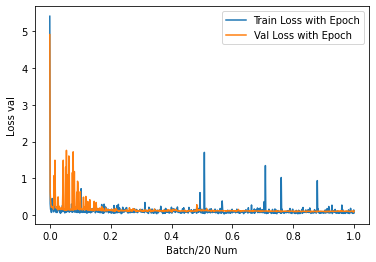

In [33]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots()

x = np.linspace( 0, 1, len(train_loss))
ax.plot(x, train_loss, label='Train Loss with Epoch')
ax.plot(x, validation_loss ,label='Val Loss with Epoch')
ax.set_xlabel('Batch/20 Num')
ax.set_ylabel('Loss val')
ax.legend()
plt.show()

In [37]:
encoder = model_utils.load_model(save_dir, 'encoder03')
decoder = model_utils.load_model(save_dir, 'decoder03')

In [38]:
data_test = pd.read_csv(processed_data_path + processed_data_files[-1])
input_seqsize = 20
rollout_len_test = 890

window_size_test = input_seqsize + rollout_len_test
data_temp = getConsecutive(data_test, window_size_test, DATA_STRIDE, FEATURE_SIZE)
model_input, state = getTestInput(data_temp, window_size_test, constant_)
test_dataset = TestDataset(model_input, state, None, input_seqsize, rollout_len_test)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1)
test_utils = ModelUtils(save_dir, 1, lstm_hidden_size, gpu_bool=gpu_bool)

Add  (911, 5, 7)  data


RMSE -- Acc      : 0.22507639516912908
RMSE -- Yaw_rate : 0.03529985117418234
RMSE -- Speed    : 0.4339554963503524
RMSE -- Yaw      : 0.4361625834528164
RMSE -- Position : 49.07353120603394
 


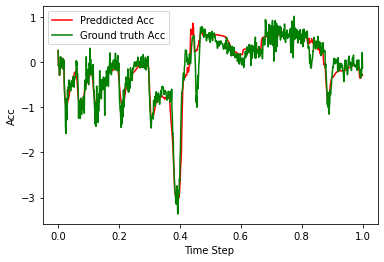

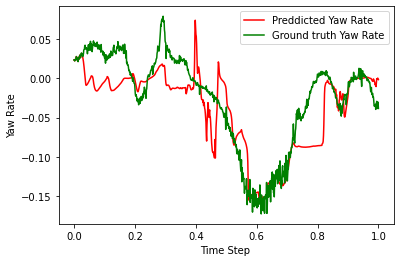

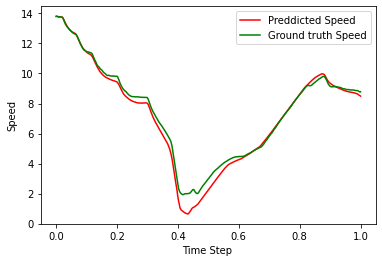

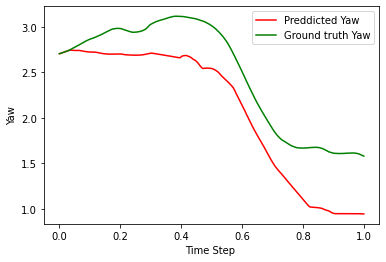

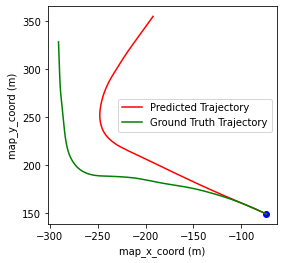

In [39]:
inputseq_len = input_seqsize
rollout_len = rollout_len_test

encoder.eval()
decoder.eval()

with torch.no_grad(): 
  for batch_index, data in enumerate(test_dataloader):

      predicted_acc = np.zeros(inputseq_len + rollout_len_test)
      predicted_yaw_rate = np.zeros(inputseq_len + rollout_len_test)

      predicted_speed = np.zeros(inputseq_len + rollout_len_test)
      predicted_yaw = np.zeros(inputseq_len + rollout_len_test)

      predicted_x = np.zeros(inputseq_len + rollout_len_test)
      predicted_y = np.zeros(inputseq_len + rollout_len_test)

      
      model_input, target, cumulated_state, command = data
      dT = cumulated_state[0, :, -1]
      # print(cumulated_state.shape)
      if gpu_bool:
              device = torch.device("cuda")
      else:
          device = torch.device("cpu")

      model_input = model_input.float().to(device)
      target = target.float().to(device)
      cumulated_state = cumulated_state.float().to(device)
      command = command.float().to(device)


      predicted_acc[:inputseq_len] = target[0, :inputseq_len, 0].cpu()
      predicted_yaw_rate[:inputseq_len] = target[0, :inputseq_len, 1].cpu()/constant_
      predicted_speed[:inputseq_len] = cumulated_state[0, :inputseq_len, -3].cpu()
      predicted_yaw[:inputseq_len] = cumulated_state[0, :inputseq_len, -2].cpu()
      predicted_x[:inputseq_len] = cumulated_state[0, :inputseq_len, 0].cpu()
      predicted_y[:inputseq_len] = cumulated_state[0, :inputseq_len, 1].cpu()

      for di in range(rollout_len):   
        # Initialize loss

        # Initialize encoder hidden state
        encoder_hidden = test_utils.init_zero_state()

        for ei in range(inputseq_len):
            encoder_hidden = encoder(model_input[:, ei, :], encoder_hidden)

        # Initialize decoder hidden state as encoder hidden state
        decoder_hidden = encoder_hidden

        decoder_input = model_input[:, input_seqlen - 1, :]
        decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)

        new_in = torch.cat((command[:, di + inputseq_len, :], decoder_output), 1)
        new_in = new_in[None, :, :]
        model_input = torch.cat((model_input[:, 1:, :], new_in), 1)

        predicted_acc[inputseq_len + di] = decoder_output[0, 0]
        predicted_yaw_rate[inputseq_len + di] = decoder_output[0, 1]/constant_

        # predicted_speed[inputseq_len + di] = predicted_speed[inputseq_len + di - 1] +  target[0, inputseq_len + di - 1, 0].cpu()*dT[inputseq_len + di - 1]
        # predicted_yaw[inputseq_len + di] = predicted_yaw[inputseq_len + di - 1] +   target[0, inputseq_len + di - 1, 1].cpu()/constant_*dT[inputseq_len + di - 1]

        predicted_speed[inputseq_len + di] = predicted_speed[inputseq_len + di - 1] +  predicted_acc[inputseq_len + di - 1]*dT[inputseq_len + di - 1]
        predicted_yaw[inputseq_len + di] = predicted_yaw[inputseq_len + di - 1] +  predicted_yaw_rate[inputseq_len + di - 1]*dT[inputseq_len + di - 1]

        predicted_x[inputseq_len + di] = predicted_x[inputseq_len + di - 1] +  predicted_speed[inputseq_len + di - 1]*np.cos(predicted_yaw[inputseq_len + di - 1])*dT[inputseq_len + di - 1]
        predicted_y[inputseq_len + di] = predicted_y[inputseq_len + di - 1] +  predicted_speed[inputseq_len + di - 1]*np.sin(predicted_yaw[inputseq_len + di - 1])*dT[inputseq_len + di - 1]
        

      acc_pred = torch.from_numpy(predicted_acc[inputseq_len:])
      yaw_rate_pred = torch.from_numpy(predicted_yaw_rate[inputseq_len:])
      speed_pred = torch.from_numpy(predicted_speed[inputseq_len:])
      yaw_pred = torch.from_numpy(predicted_yaw[inputseq_len:])
      x_pred = torch.from_numpy(predicted_x[inputseq_len:])
      y_pred = torch.from_numpy(predicted_y[inputseq_len:])

      rsme_acc = torch.sqrt(criterion(target[:, inputseq_len:, 0].cpu(), acc_pred.unsqueeze(0)))
      rsme_yaw_rate = torch.sqrt(criterion(target[:, inputseq_len:, 1].cpu()/constant_, yaw_rate_pred.unsqueeze(0)))
      rsme_speed = torch.sqrt(criterion(cumulated_state[:, inputseq_len:, -3].cpu(), speed_pred.unsqueeze(0)))
      rsme_yaw = torch.sqrt(criterion(cumulated_state[:, inputseq_len:, -2].cpu(), yaw_pred.unsqueeze(0)))
      mse_x = criterion(cumulated_state[:, inputseq_len:, 0].cpu(), x_pred.unsqueeze(0))
      mse_y = criterion(cumulated_state[:, inputseq_len:, 1].cpu(), y_pred.unsqueeze(0))
      rsme_position = torch.sqrt(mse_x + mse_y)

      print(f"RMSE -- Acc      : {rsme_acc}")
      print(f"RMSE -- Yaw_rate : {rsme_yaw_rate}")
      print(f"RMSE -- Speed    : {rsme_speed}")
      print(f"RMSE -- Yaw      : {rsme_yaw}")
      print(f"RMSE -- Position : {rsme_position}")
      print(' ')  

      visualize_result_state(predicted_acc, target[0, :, 0].cpu(), "Acc")
      visualize_result_state(predicted_yaw_rate, target[0, :, 1].cpu()/constant_, "Yaw Rate")
      visualize_result_state(predicted_speed, cumulated_state[0, :, 2].cpu(), "Speed")
      visualize_result_state(predicted_yaw, cumulated_state[0, :, 3].cpu(), "Yaw")
      visualize_result_position(predicted_x, predicted_y, cumulated_state[0, :, 0].cpu(), cumulated_state[0, :, 1].cpu())

      break